#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
# import julia;
# julia.install()

In [2]:
import numpy as np
import numdifftools as nd
import math
import matplotlib.pyplot as plt
from datetime import datetime
# from scipy.integrate import odeint
# from torchdiffeq import odeint
import torch
import inspect
import random

In [3]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [4]:
# from diffeqpy import ode
from diffeqpy import de

In [5]:
from vehicles import shipClarke83
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [6]:
def R2D(value):  # radians to degrees
    return value * 180 / math.pi

In [7]:
mp = 96 #  (submerged) [kg/m]

In [8]:
# q0=[i for i in range(12)]
max_t = 2 # 10 #600  
dt = 0.5
t=np.arange(0,max_t,dt)
ds = 0.025
print(t)

[0.  0.5 1.  1.5]


In [9]:
node_N=4

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]

In [13]:
diag_DT = 1.5*np.array([1, 1, 1]) # [N/m]  , p.99 in [1]

In [14]:
DT=np.diag(diag_DT) # (35) in [2]

In [15]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [16]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
# diag_CT = 1e10*np.array([1, 1, 1]) 

In [17]:
CT=np.diag(diag_CT)

In [18]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [19]:
from sympy import *

In [20]:
rng = np.random.default_rng()

In [21]:
# Dphi1, Dphi2, Dphi3 = symbols("Dphi1 Dphi2 Dphi3")
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [22]:
def C1(dx,dy,dz):
    return np.vstack([dx**2,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])

In [23]:
dx**2

array([0.06493539, 1.62944121, 0.3191618 , 0.03414557])

In [24]:
C1(dx,dy,dz)

array([[ 0.06493539,  1.62944121,  0.3191618 ,  0.03414557],
       [-0.45353474,  2.73102105,  2.14818984, -0.01977854],
       [-1.79658645,  1.92200006,  0.37817234,  0.02535051]])

In [25]:
startTime1 = datetime.now()
C1(dx,dy,dz)
print(datetime.now() - startTime1)

0:00:00.001417


In [215]:
C1(dx,dy,dz)

array([[ 0.06493539,  1.62944121,  0.3191618 ,  0.03414557],
       [-0.45353474,  2.73102105,  2.14818984, -0.01977854],
       [-1.79658645,  1.92200006,  0.37817234,  0.02535051]])

In [216]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [218]:
1/2*d0*qw

390.0125

In [221]:
1/2*d0*qw*np.dot(DT,np.array([[0.06493539,1.62944121],[-0.45353474,2.73102105],
                              [-1.79658645,1.92200006]])) 

array([[   37.98842069,   953.25365987],
       [ -265.32632668,  1597.69852089],
       [-1051.03675925,  1124.4060726 ]])

In [27]:
def fD(dx,dy,dz,DT):
#     print(dx)
#     print(C1(dx,dy,dz).shape)
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz))

In [28]:
fD(dx,dy,dz,DT)

array([[   37.98841893,   953.25365811,   186.7156392 ,    19.97580097],
       [ -265.32632642,  1597.69852159,  1256.73133243,   -11.57081432],
       [-1051.03676169,  1124.40607416,   221.23790796,    14.83052315]])

In [29]:
fD(dx,dy,dz,DT).T

array([[   37.98841893,  -265.32632642, -1051.03676169],
       [  953.25365811,  1597.69852159,  1124.40607416],
       [  186.7156392 ,  1256.73133243,   221.23790796],
       [   19.97580097,   -11.57081432,    14.83052315]])

In [30]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT)
print(datetime.now() - startTime1)

0:00:00.000256


In [31]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [32]:
# Mat=np.matrix([[1.3,.4,6.7],[9,7,6],[3.3,5.6,7]])

In [33]:
I=np.identity(3)

In [34]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT))
print(datetime.now() - startTime1)

0:00:00.002064


In [35]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [36]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [37]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [38]:
DR=np.diag(diag_DR) 

In [39]:
dI= 0.69# Inner diameter of pipe, [m]

In [40]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [41]:
Ar

0.08091250419136858

In [42]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [43]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223]])

In [44]:
from numpy import linalg as LA

In [45]:
def k_sigma(hi,d0,fg_e):
    ans=[]
#     print('hi',hi)
    for it in hi:
#         print(it)
        if it<0:
            ans.append(0)
        elif 0<=it<=d0/20:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*10*it**2/d0))
        else:
#             print(LA.norm(fg_e,2)/(d0/8-d0/40)*10*hi**2/d0)
            ans.append(np.float64(LA.norm(fg_e,2)/(d0/8-d0/40)*(it-d0/40)))
#     print(ans)         
     
    return np.array(ans).reshape(node_N,1)   

In [46]:
x,y,z=np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)]),np.array([2.3 for i in range(node_N)])

In [47]:
def hi(x,y,z,d0):
    return (np.dot(np.array([x,y,z]).T,[0,0,1])+d0/2).reshape(node_N,1) 

In [48]:
startTime1 = datetime.now()
hi(x,y,z,d0)
print(datetime.now() - startTime1)

0:00:00.000140


In [49]:
k_sigma(hi(x,y,z,d0),d0,fg_e)

array([[8964.69710988],
       [8964.69710988],
       [8964.69710988],
       [8964.69710988]])

In [50]:
startTime1 = datetime.now()
k_sigma(hi(x,y,z,d0),d0,fg_e)
print(datetime.now() - startTime1)

0:00:00.000452


In [51]:
# TODO: force shoud be acting only at nodes that are in contact with the seabed
def sigma(x,y,z):
    return (k_sigma(hi(x,y,z,d0),d0,fg_e)*np.array([0,0,1]))

In [52]:
startTime1 = datetime.now()
sigma(x,y,z)
print(datetime.now() - startTime1)

0:00:00.000751


In [53]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [54]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [55]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [56]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
#     print(Re_t_(xyz[0]))
    return np.apply_along_axis(Re_t_, 1, xyz)

In [57]:
φ, θ, ψ

(array([ 1.29673504,  0.34248995, -0.6285853 , -0.99595637]),
 array([-0.7521129 ,  0.44449041,  0.92952947, -0.03013482]),
 array([ 0.9424811 ,  0.19414624,  0.95467695, -1.37537876]))

In [58]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.42922646, -0.59078365, -0.68318322],
       [-0.16762111,  0.69116038, -0.70299395],
       [ 0.88750651,  0.41625954,  0.19763651]])

In [59]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002271


In [60]:
Ret

array([[[ 0.42922646, -0.59078365, -0.68318322],
        [-0.16762111,  0.69116038, -0.70299395],
        [ 0.88750651,  0.41625954,  0.19763651]],

       [[ 0.88586821, -0.17418197,  0.42999787],
        [ 0.32341849,  0.89636485, -0.30320049],
        [-0.33262291,  0.40766494,  0.85039479]],

       [[ 0.34568971, -0.48821629,  0.80133855],
        [ 0.38784619,  0.85196722,  0.35174876],
        [-0.85444366,  0.18920017,  0.48386913]],

       [[ 0.19408801,  0.9805213 , -0.03013026],
        [-0.52844177,  0.13038007,  0.83889828],
        [ 0.82648602, -0.14689801,  0.54345362]]])

In [61]:
# vessel motion
# Fossen book p.101, p.190, p.384, p.431
# Fossen paper, section 6

In [62]:
# Fossen paper, equation (12)

In [63]:
# φ,θ,ψ=1,2,3

In [64]:
def Re_b(Ret):
    return np.dot(Ret, Rb_t ) # (5) in[3]

In [65]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000214


In [66]:
# p=np.dot(Re_b, phi) # (41) in[3]

In [67]:
# def d_s(da,db,dc,dt,ds):
    
def d_s(da,db,dc,x,y,z):
#     return np.vstack([da*dt/ds,db*dt/ds,dc*dt/ds])
#     print(np.diff(da))

    ds=np.sqrt(np.diff(x,prepend=x[0])**2+np.diff(y,prepend=y[0])**2
                 +np.diff(z,prepend=z[0])**2)
#     print(ds)
    ds[ds == 0] = 1
    return np.vstack([np.diff(da,prepend=da[0])/ds,np.diff(db,prepend=db[0])/ds,np.diff(dc,prepend=dc[0])/ds])

In [68]:
# a=[1,2,3]
# np.diff(a,prepend=a[0])

In [69]:
x,y,z=100*rng.standard_normal(node_N),100*rng.standard_normal(node_N),100*rng.standard_normal(node_N)


In [222]:
d_s(x,y,z,x,y,z)

array([[ 0.        ,  0.97303919, -0.49304885,  0.86475016],
       [ 0.        ,  0.09824755,  0.70368535,  0.44023383],
       [ 0.        ,  0.20866755,  0.51159531,  0.2416637 ]])

In [70]:
startTime1 = datetime.now()
d_s(x,y,z,x,y,z)
print(datetime.now() - startTime1)

0:00:00.000895


In [71]:
# φ,θ,ψ=np.array([2.3 for i in range(node_N)]),np.array([1.3 for i in range(node_N)]),np.array([2.1 for i in range(node_N)])


In [72]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [224]:
def ne(x,y,z,Ret):
#     print(np.multiply(Re_t(φ,θ,ψ),CT).shape)
#     print(np.multiply(np.multiply(Re_t(φ,θ,ψ),CT),
#                          Re_t(φ,θ,ψ)).shape)
#     print(d_s(dx,dy,dz,dt,ds).shape)
    
    A=np.multiply(np.multiply(Ret,CT),Ret)
#     B=d_s(dx,dy,dz,dt,ds).T
    B=d_s(x,y,z,x,y,z).T
    
    print(A)
    print(B)
    
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)
#     return np.array(ans)

In [225]:
def ne_(x,y,z,dx,dy,dz):
#     print('ho',fg_e.shape)
#     print(fD(dx,dy,dz,DT))
#     print(sigma(x,y,z))
    return -fg_e.T-fD(dx,dy,dz,DT) #-sigma(x,y,z).T
#     return -fg_e-fD(dx,dy,dz,DT)

In [226]:
sigma(x,y,z)

array([[     0.       ,      0.       ,      0.       ],
       [     0.       ,      0.       ,      0.       ],
       [     0.       ,      0.       ,      0.       ],
       [     0.       ,      0.       , 101843.9918385]])

In [227]:
ne_(x,y,z,dx,dy,dz)

array([[  -37.98841893,  -953.25365811,  -186.7156392 ,   -19.97580097],
       [  265.32632642, -1597.69852159, -1256.73133243,    11.57081432],
       [  922.87221946, -1252.57061639,  -349.40245019,  -142.99506538]])

In [228]:
# mp*ddp = d_s(ne,ds)+np.dot(Re_b,ne_)

In [236]:
startTime1 = datetime.now()
ne(x,y,z,Ret)
print(datetime.now() - startTime1)

[[[1.84235357e+08 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 4.77702671e+08 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 3.90601905e+07]]

 [[7.84762477e+08 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 8.03469940e+08 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 7.23171296e+08]]

 [[1.19501376e+08 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 7.25848145e+08 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 2.34129335e+08]]

 [[3.76701567e+07 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 1.69989623e+07 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 2.95341839e+08]]]
[[ 0.          0.          0.        ]
 [ 0.97303919  0.09824755  0.20866755]
 [-0.49304885  0.70368535  0.51159531]
 [ 0.86475016  0.44023383  0.2416637 ]]
0:00:00.002254


In [238]:
np.dot([[7.84762477e+08, 0.00000000e+00, 0.00000000e+00],
  [0.00000000e+00, 8.03469940e+08, 0.00000000e+00],
  [0.00000000e+00, 0.00000000e+00, 7.23171296e+08]],
       np.matrix([
 [ 0.97303919 , 0.09824755 , 0.20866755]]).T)

matrix([[7.63604645e+08],
        [7.89389531e+07],
        [1.50902383e+08]])

In [239]:
ne(x,y,z,Ret)

[[[1.84235357e+08 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 4.77702671e+08 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 3.90601905e+07]]

 [[7.84762477e+08 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 8.03469940e+08 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 7.23171296e+08]]

 [[1.19501376e+08 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 7.25848145e+08 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 2.34129335e+08]]

 [[3.76701567e+07 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 1.69989623e+07 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 2.95341839e+08]]]
[[ 0.          0.          0.        ]
 [ 0.97303919  0.09824755  0.20866755]
 [-0.49304885  0.70368535  0.51159531]
 [ 0.86475016  0.44023383  0.2416637 ]]


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.63604648e+08,  7.89389491e+07,  1.50902385e+08],
       [-5.89200157e+07,  5.10768708e+08,  1.19779469e+08],
       [ 3.25752739e+07,  7.48351829e+06,  7.13734015e+07]])

In [79]:
startTime1 = datetime.now()
ne_(x,y,z,dx,dy,dz)
print(datetime.now() - startTime1)

0:00:00.000359


In [80]:
Re_b(Ret).shape

(4, 3, 3)

In [81]:
def Irho_e(Ret):
    return np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 

In [82]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000333


In [83]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ)*np.cos(ψ),-np.sin(ψ),0],
                  [np.cos(θ)*np.sin(ψ),np.cos(ψ),0],
                  [-np.sin(θ),0,1]])

In [84]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [85]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000744


In [86]:
def ωe(φ,θ,ψ):  # (100) in [2]
    A=Π(φ,θ,ψ)
#     print(A)
    B=np.array([φ,θ,ψ]).T
#     print(B)
#     ans=[]
#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
    return np.einsum('ijk,ik->ij', A,B)    
#     return np.array(ans) 
#     ans=[]
#     for i in range(len(φ)):
#         ans.append(np.dot(Π(φ[i],θ[i],ψ[i]),np.array([φ[i],θ[i],ψ[i]])))  # (100) in [2]
#     return np.vstack(ans)    

In [87]:
# np.dot(np.matrix([[-0.13504574, -0.86320937,  0.        ],
#   [ 0.23090749, -0.5048461 ,  0.        ],
#   [-0.96355819,  0.,          1.        ]]),np.array([2.3, 1.3, 2.1]))

In [88]:
startTime1 = datetime.now()
ωe(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.000734


In [89]:
diag_CR = 1e11*np.array([1, 1, 1]) 
# diag_CR = 1e7*np.array([1, 1, 1]) 
CR=np.diag(diag_CR)

In [90]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [240]:
def me(φ,θ,ψ,Ret):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=ωe(φ,θ,ψ)
    ans=[]
    print(A)
    print(B)
    return np.einsum('ijk,ik->ij', A,B) 

#     for i in range(len(A)):
#         ans.append(np.dot(A[i],B[i]))
#     return np.array(ans)
#     tmp=[]
#     for i in range(len(φ)):
#         tmp.append(np.dot(np.dot(Re_t(φ[i],θ[i],ψ[i]),CR),Re_t(φ[i],θ[i],ψ[i]).T))
        
#     tmp1= ωe(φ,θ,ψ)
    
#     ans=[]
#     for i in range(len(tmp1)):
#         ans.append(np.dot(np.array(tmp[i]),tmp1[i] ))
#     return np.array(ans).reshape(3,-1)

In [241]:
startTime1 = datetime.now()
me_=me(φ,θ,ψ,Ret)
print(datetime.now() - startTime1)

[[[1.84235357e+10 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 4.77702671e+10 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 3.90601905e+09]]

 [[7.84762477e+10 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 8.03469940e+10 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 7.23171296e+10]]

 [[1.19501376e+10 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 7.25848145e+10 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 2.34129335e+10]]

 [[3.76701567e+09 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 1.69989623e+09 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 2.95341839e+10]]]
[[ 1.16506658  0.32401101  1.82838873]
 [ 0.21764591  0.49579523  0.0468763 ]
 [-0.97590966  0.23026388  1.45838658]
 [-0.22286444  0.97070497 -1.40538718]]
0:00:00.018461


In [242]:
me_

array([[ 2.14646457e+10,  1.54780923e+10,  7.14172122e+09],
       [ 1.70800346e+10,  3.98356563e+10,  3.38995911e+09],
       [-1.16622548e+10,  1.67136607e+10,  3.41451080e+10],
       [-8.39533854e+08,  1.65009772e+09, -4.15069634e+10]])

In [94]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [95]:
# np.dot(Re_b, np.dot( Irho_e, (np.dot(Π(φ,θ,ψ), np.array([ddφ,ddθ,ddψ])))))=
# -np.dot(Re_b,np.dot(Irho_e,np.dot(Π(dφ,dθ,dψ),np.array([dφ,dθ,dψ])))-
# np.cross(np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ])),np.dot(Irho_e, np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))+
# np.dot(Re_b,d_s(me_[0],me_[1],me_[2],dt,ds)+d_s(me_[0],me_[1],me_[2],dt,ds))+
# np.cross(d_s(x,y,z,dt,ds),ne(x,y,z,φ,θ,ψ,dt,ds))+
# np.dot(Re_b,-np.dot(DR,np.dot(Π(φ,θ,ψ),np.array([dφ,dθ,dψ]))))

In [96]:
ne_(x,y,z,dx,dy,dz)

array([[  -37.98841893,  -953.25365811,  -186.7156392 ,   -19.97580097],
       [  265.32632642, -1597.69852159, -1256.73133243,    11.57081432],
       [  922.87221946, -1252.57061639,  -349.40245019,  -142.99506538]])

In [97]:
C=ne(x,y,z,Ret)
  
a,b,c=C[:,0],C[:,1],C[:,2]

In [98]:
d_s(a,b,c,x,y,z)

array([[       0.        ,  5517069.57472807, -8965206.94685648,
          528492.89361187],
       [       0.        ,   570336.59449414,  4706780.63232596,
        -2907063.82536705],
       [       0.        ,  1090274.8664382 ,  -339227.9775424 ,
         -279601.96599147]])

In [99]:
Re_b(Ret).shape

(4, 3, 3)

In [100]:
ne_(x,y,z,dx,dy,dz).T

array([[  -37.98841893,   265.32632642,   922.87221946],
       [ -953.25365811, -1597.69852159, -1252.57061639],
       [ -186.7156392 , -1256.73133243,  -349.40245019],
       [  -19.97580097,    11.57081432,  -142.99506538]])

In [101]:
type(x),y,z,dx,type(dy),dz

(numpy.ndarray,
 array([-86.09482545, -72.49661338,  -7.93607821,  68.27936806]),
 array([-87.78180175, -58.90061557, -11.96363333,  29.87437512]),
 array([-0.25482423,  1.27649567, -0.56494407, -0.18478521]),
 numpy.ndarray,
 array([-1.31982544,  1.0517433 ,  0.25605881,  0.14137528]))

In [102]:
ne_(x,y,z,dx,dy,dz).T+np.einsum('ijk,ik->ij', Re_b(Ret),ne_(x,y,z,dx,dy,dz).T)

array([[ -841.53532879,  -193.69655301,  1181.99511063],
       [-2058.02318512, -2958.33914317, -2652.00180183],
       [   82.30574468, -2522.74406042,  -596.70330264],
       [   -8.19895672,   -96.32284914,  -238.91570141]])

In [103]:
ne_(x,y,z,dx,dy,dz).T

array([[  -37.98841893,   265.32632642,   922.87221946],
       [ -953.25365811, -1597.69852159, -1252.57061639],
       [ -186.7156392 , -1256.73133243,  -349.40245019],
       [  -19.97580097,    11.57081432,  -142.99506538]])

### Catenary

In [104]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [105]:
pipe_weight_per_unit_length = mp #  (submerged) [kg/m]  # 113.07 - not submerged

In [106]:
Fx_0=82945396

In [107]:
Ws = pipe_weight_per_unit_length*9.81 # [N/m]
h=700

In [108]:
S=math.sqrt(h*(2*Fx_0/Ws -h))
horizontal_length=(Fx_0/Ws -h)*np.log((S+Fx_0/Ws)/(Fx_0/Ws-h))

In [109]:
delta_x=horizontal_length/(node_N-1)

In [110]:
x0=[i*delta_x for i in range(node_N)]
z0=[]
for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws,Fx_0))

In [111]:
x0,z0

([0.0, 3684.228281487207, 7368.456562974414, 11052.68484446162],
 [0.0, 77.06804644731459, 308.40705929683963, 694.4218951076863])

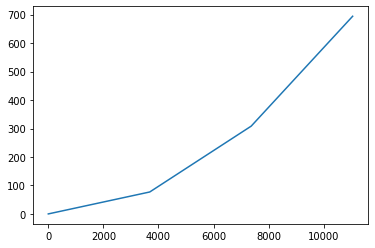

In [112]:
plt.plot(x0, z0)
plt.show()

In [113]:
rng = np.random.default_rng()
q0=np.zeros(12*node_N)

In [114]:

for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0
#     elif j==7 or j==9 or j==11: 
    elif j==9 or j==11: 
#         q0[(j-1)*node_N:j*node_N]=rng.standard_normal(node_N)
        q0[(j-1)*node_N:j*node_N]=np.array([0.01 for x in range(node_N)])

In [115]:
q0

array([0.00000000e+00, 3.68422828e+03, 7.36845656e+03, 1.10526848e+04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 7.70680464e+01, 3.08407059e+02, 6.94421895e+02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e-02, 1.00000000e-02, 1.00000000e-02, 1.00000000e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e-02, 1.00000000e-02, 1.00000000e-02, 1.00000000e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00])

In [116]:
q0[node_N*6]=0

In [117]:
q0[node_N*8]=0

In [118]:
q0[node_N*10]=0

### Vessel

In [119]:
class VesselSemisub: # Semisub model from Fossen
    
    def __init__(self):
        
        MRB = 1.0e10 * np.array(
            [
                [0.0027, 0, 0, 0, -0.0530, 0],
                [0, 0.0027, 0, 0.0530, 0, -0.0014],
                [0, 0, 0.0027, 0, 0.0014, 0],
                [0, 0.0530, 0, 3.4775, 0, -0.0265],
                [-0.0530, 0, 0.0014, 0, 3.8150, 0],
                [0, -0.0014, 0, -0.0265, 0, 3.7192],
            ],
            float,
        )

        MA = 1.0e10 * np.array(
            [
                [0.0017, 0, 0, 0, -0.0255, 0],
                [0, 0.0042, 0, 0.0365, 0, 0],
                [0, 0, 0.0021, 0, 0, 0],
                [0, 0.0365, 0, 1.3416, 0, 0],
                [-0.0255, 0, 0, 0, 2.2267, 0],
                [0, 0, 0, 0, 0, 3.2049],
            ],
            float,
        )

        self.D = 1.0e09 * np.array(
            [
                [0.0004, 0, 0, 0, -0.0085, 0],
                [0, 0.0003, 0, 0.0067, 0, -0.0002],
                [0, 0, 0.0034, 0, 0.0017, 0],
                [0, 0.0067, 0, 4.8841, 0, -0.0034],
                [-0.0085, 0, 0.0017, 0, 7.1383, 0],
                [0, -0.0002, 0, -0.0034, 0, 0.8656],
            ],
            float,
        )

#         self.G = 1.0e10 * np.diag([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.G =1.0e10 *np.array([0.0, 0.0, 0.0006, 1.4296, 2.6212, 0.0])
        self.M = MRB + MA
#         print(self.G,self.M)
    def tau(self, dη, ddη):
        return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)
#         return (np.matmul(self.M,ddη) + np.matmul(self.D, dη) + self.G)/10000000

In [120]:
V=VesselSemisub()

In [121]:
dη=np.array([1,2,3,4,5,6])
ddη=np.array([1.3,2.4,3.5,4.6,5.7,6.8])

In [122]:
tau_force = V.tau(dη, ddη)

In [123]:
tau_force.shape

(6,)

In [124]:
np.matmul(np.array([[1.1,1.2],[1,2]]),np.array([1,2]))

array([3.5, 5. ])

In [125]:
t

array([0. , 0.5, 1. , 1.5])

In [126]:
sampleTime = 0.01                 # sample time [seconds]
N = 25_000                         # number of samples

In [127]:
N

25000

In [128]:
vehicle_1=semisub('DPcontrol',10.,10.,40.0,0,0) 

In [129]:
[simTime_1, simData_1] = simulate(N, sampleTime, vehicle_1)

In [130]:
vehicle_2=semisub('DPcontrol',-10.,-10.,40.0,0,0) 

In [131]:
[simTime_2, simData_2] = simulate(N, sampleTime, vehicle_2)

In [132]:
simData_1.shape

(25001, 24)

In [133]:
simData=np.concatenate([simData_1,simData_2], axis=0)

In [134]:
simData.shape

(50002, 24)

In [135]:
# ans_t = simTime_1

In [136]:
simData.shape

(50002, 24)

In [137]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=0.01

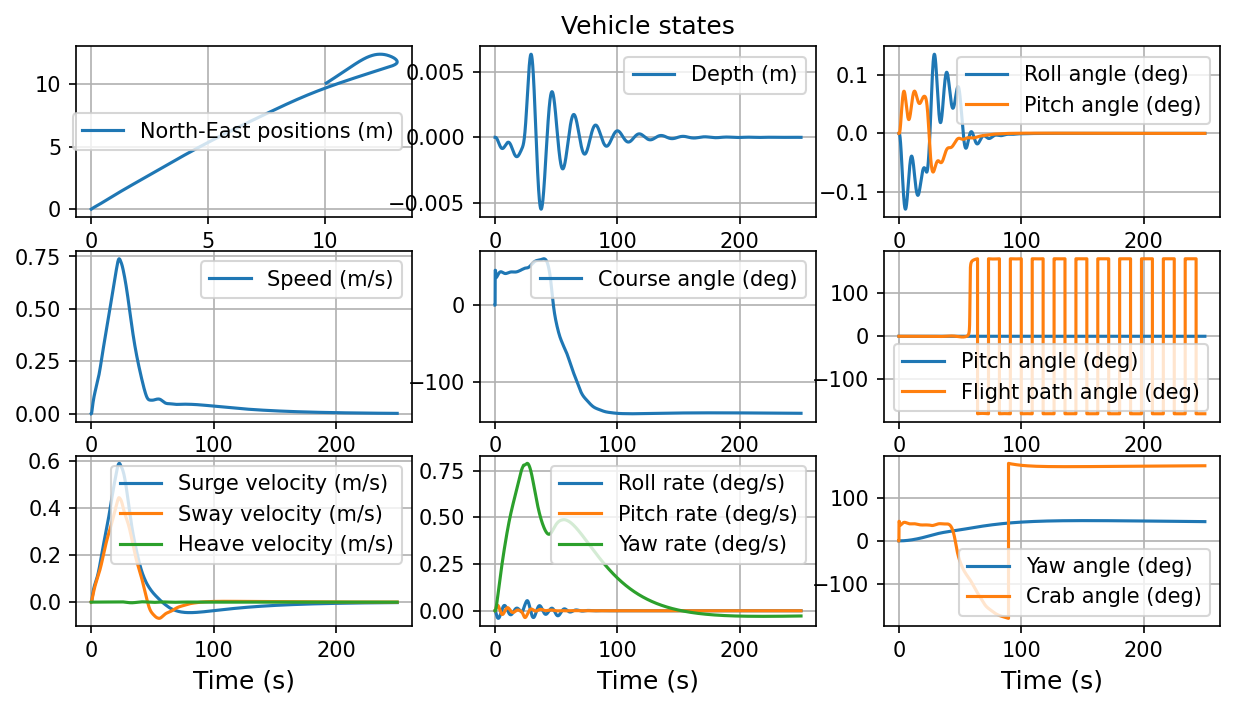

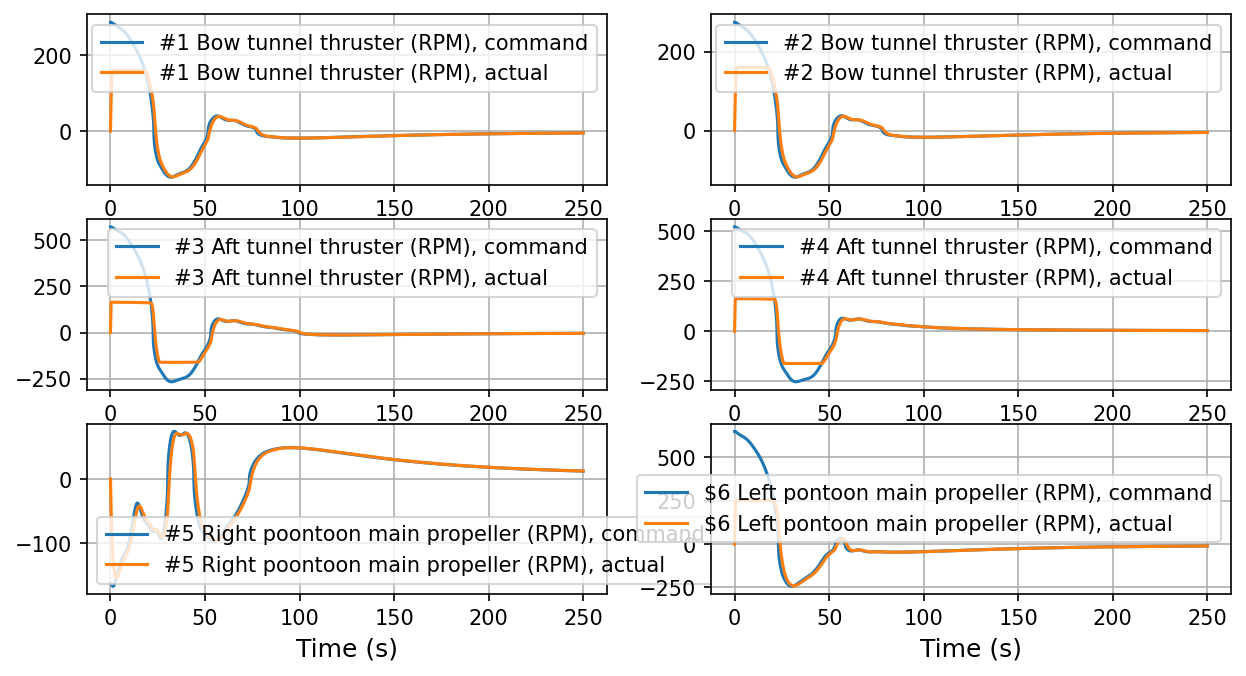

In [138]:
plotVehicleStates(simTime_1, simData_1, 1)                    
plotControls(simTime_1, simData_1, vehicle_1, 2)

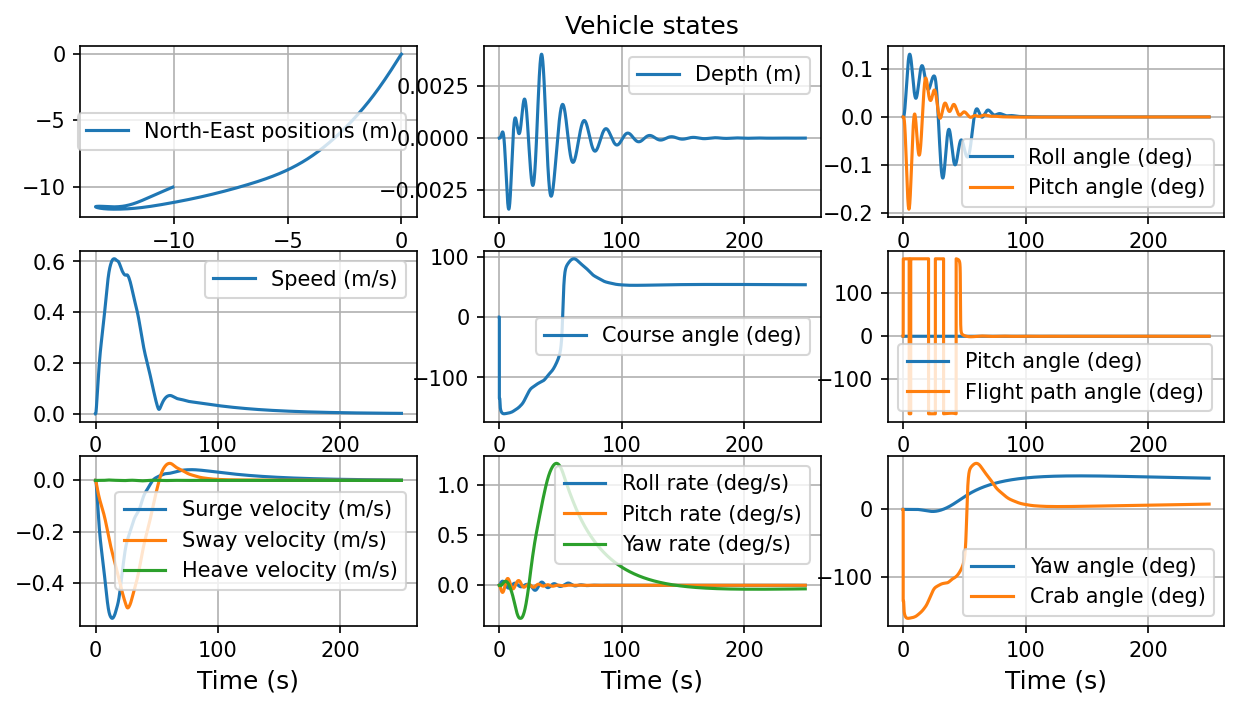

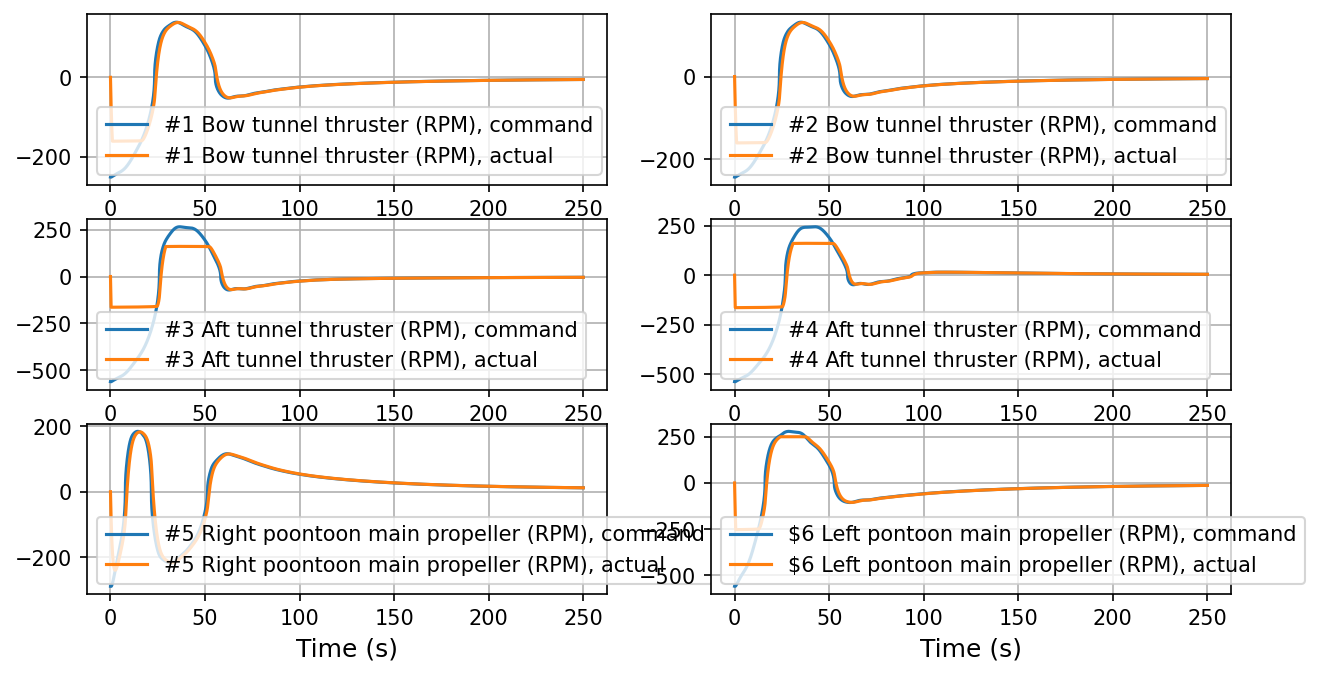

In [139]:
plotVehicleStates(simTime_2, simData_2, 1)                    
plotControls(simTime_2, simData_2, vehicle_2, 2)

In [140]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'                  # browser for visualization of animated GIF

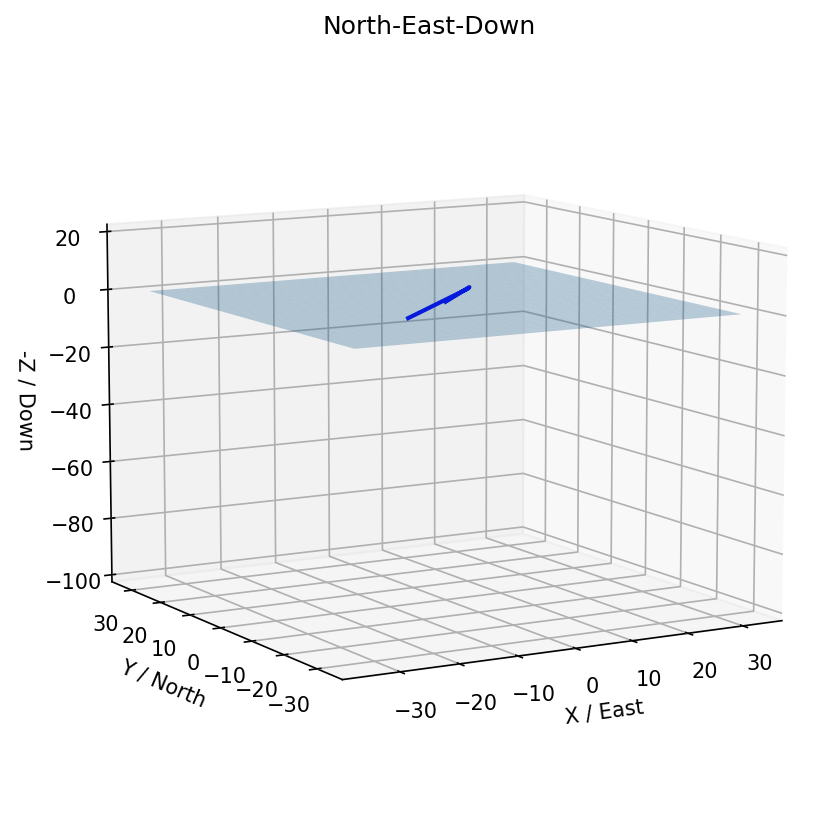

In [141]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

### Modelling

In [142]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [143]:
# simData[1]

In [144]:
simD_1=np.insert(simData_1, 0, simData_1[0], axis=0)
simD_2=np.insert(simData_2, 0, simData_2[0], axis=0)

In [145]:
diff_1=np.diff(simD_1,axis=0)
diff_2=np.diff(simD_2,axis=0)

In [146]:
diff=np.concatenate([diff_1,diff_2], axis=0)

In [147]:
diff.shape

(50002, 24)

In [148]:
V=VesselSemisub()

In [149]:
# thres =0.1

In [150]:
def retrieve_name(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    return [var_name for var_name, var_val in callers_local_vars if var_val is var]

In [151]:
simD=np.concatenate([simD_1,simD_2], axis=0)

In [152]:
simD.shape

(50004, 24)

In [153]:
SD0=simD[:, 0]
SD1=simD[:, 1]
SD2=simD[:, 2]
SD3=simD[:, 3]
SD4=simD[:, 4]
SD5=simD[:, 5]
SD6=simD[:, 6]
SD7=simD[:, 7]
SD8=simD[:, 8]
SD9=simD[:, 9]
SD10=simD[:, 10]
SD11=simD[:, 11]
Diff6=diff[:, 6]
Diff7=diff[:, 7]
Diff8=diff[:, 8]
Diff9=diff[:, 9]
Diff10=diff[:, 10]
Diff11=diff[:, 11]

In [202]:
class Time:
    def __init__(self,up):
#         self.my_max = sampleTime*N*2
        self.my_time=0
#         self.my_n=0
        self.my_update=up

In [203]:
co=Time(1e-3)

In [204]:
def grayscott1d(Q,p,t):
#     Q,t=np.array(Q),np.array(t)
#     print(t)
#     dt=0
#     dt=abs(t-co.time)
#     print('dt',t,co.time,dt)
#     co.time+=sampleTime
#     co.time += 0.1
#     if co.my_time%co.my_max==0:
#         co.my_n+=1
        
    co.my_time+=co.my_update     
    
#     print(Q)   
#     print(abs(co.my_time))
    
    idx = find_nearest(ans_t,  t%len(ans_t)) #!!!!!!!!!!!!!!!!!!!!!
#     print(idx)
#     print(t)
#     print(idx)
#     ind=ans_t.index(val)
    # State vectors
    x_ve = SD0[idx]
    y_ve = SD1[idx]
    z_ve = SD2[idx]
#     print(x_ve,y_ve,z_ve)
#     phi_ve = R2D(ssa(simData[:, 3][idx]))
#     theta_ve = R2D(ssa(simData[:, 4][idx]))
#     psi_v = R2D(ssa(simData[:, 5][idx]))
    phi_ve = ssa(SD3[idx])
    theta_ve = ssa(SD4[idx])
    psi_v = ssa(SD5[idx])
    u_ve = SD6[idx]
    v_ve = SD7[idx]
    w_ve = SD8[idx]
    p_ve = SD9[idx]
    q_ve = SD10[idx]
    r_ve = SD11[idx]
    
    du_ve = Diff6[idx]/sampleTime
    dv_ve = Diff7[idx]/sampleTime
    dw_ve = Diff8[idx]/sampleTime
    dp_ve = Diff9[idx]/sampleTime
    dq_ve = Diff10[idx]/sampleTime
    dr_ve = Diff11[idx]/sampleTime
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    ddη=np.array([du_ve, dv_ve, dw_ve, dp_ve, dq_ve, dr_ve])
    
    tau_force = V.tau(dη, ddη)
    
    
    
    
#     p_ve = R2D(simData[:, 9][idx])
#     q_ve = R2D(simData[:, 10][idx])
#     r_ve = R2D(simData[:, 11][idx])

#     if t>dt*co.count:
#         co.count+=1
        
#     print(type(Q))
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
#     print(x0[-1],y0[-1])

    x[-1]=x_ve+x0[-1]
    y[-1]=y_ve
    z[-1]=z_ve+z0[-1]
#     print( x[-1], y[-1], z[-1])
#     x[0]=0
#     y[0]=0
#     z[0]=0
#     print(z)
#     print(z_ve)
#     print(x_ve,y_ve,z_ve)
#     print(x[0],y[0],z[0])
#     print(x[-1],y[-1],z[-1])
#     print()
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    
#     dx[0]=0
#     dy[0]=0
#     dz[0]=0
    
    
    dx[-1]=u_ve
    dy[-1]=v_ve 
    dz[-1]=w_ve
#     print(dx,dy.shape, dx.shape)
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)
    
    φ[-1]=phi_ve
    θ[-1]=theta_ve
    ψ[-1]=psi_v
    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    dφ[-1]=p_ve
    dθ[-1]= q_ve
    dψ[-1]=r_ve
#     print(z)    
#     print(t)
    
#     ddx = np.empty_like(y)
#     ddy = np.empty_like(y)
#     ddz = np.empty_like(y)
#     ddφ = np.empty_like(y)
#     ddθ = np.empty_like(y)
#     ddψ= np.empty_like(y)
    C=ne(x,y,z,Ret)
#     print('C',C)
  
    a,b,c=C[:,0],C[:,1],C[:,2]
#     print('abc',a,b,c)
#     print(a,C)
#     print(a)
    
#     for it in [φ,θ,ψ,x,y,z,dx,dy,dz]:
#         print(it)
    # here single Re_b(φ,θ,ψ) etc.
#     print(np.einsum('ijk,ik->ij', Re_b(φ,θ,ψ).astype(float), ne_(x,y,z,dx,dy,dz).astype(float).T))
#     print(ne_(x,y,z,dx,dy,dz).astype(float))
    Z0=np.zeros((node_N,3))
    Z0[-1]=tau_force[:3]
    Z1 = d_s(a,b,c,x,y,z).T
    Z2 =np.einsum('ijk,ik->ij', Re_b(Ret), ne_(x,y,z,dx,dy,dz).T)
    Z=Z1 + Z2 + Z0
    
#     if np.isnan(np.sum(Z0)):
#         print('Z0 NaN',np.isnan(np.sum(Z0)))
#     if max(abs(np.amax(Z0)), abs(np.amin(Z0)))>thres :
#         print('Z0', Z0) 
                  
#     if np.isnan(np.sum(Z1)):
#         print('Z1 NaN',np.isnan(np.sum(Z1)))
#     if max(abs(np.amax(Z1)), abs(np.amin(Z1)))>thres :
#         print('Z1', Z1)    
                  
#     if np.isnan(np.sum(Z2)):
#         print('Z2 NaN',np.isnan(np.sum(Z2)))
#     if max(abs(np.amax(Z2)), abs(np.amin(Z2)))>thres :
#         print('Z2', Z2)      
#     print(Z.shape)
    
    
    ddx,ddy, ddz = (1/Ws*Z).T
#     print(ddx,ddy, ddz)
#     print(ddx,ddy, ddz)
#     print('ddx',ddx)  
#     print('ddy',ddy) 
#     print('ddz',ddz) 
    
    me_=me(φ,θ,ψ,Ret)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)

    
    C1=np.einsum('ijk,ik->ij', Re_b(Ret).astype(np.float32), np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), np.array([dφ,dθ,dψ]).astype(np.float32).T)))
        
    C2= np.cross(np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T),
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                           np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)))
    
#     print(Re_b(φ,θ,ψ).shape)
# #     print(me_)
# #     print(me_[:,0])
#     print(d_s(me_[:,0],me_[:,1],me_[:,2],dt,ds).shape)
# #     print(Irho_e(φ,θ,ψ).shape)
#     print(d_s(me_[:,0],me_[:,1],me_[:, 2],dt,ds))
#     print(me_)
#     print('d_s',d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z))
    C3= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),d_s(me_[:,0],me_[:,1],me_[:, 2],x,y,z).astype(np.float32).T)
    
#     print(d_s(x,y,z,dt,ds).shape)
#     print(ne(x,y,z,φ,θ,ψ,dt,ds).T.shape)
    C4= np.cross(d_s(x,y,z,x,y,z).T,ne(x,y,z,Ret))
#     print(np.dot(DR,K).shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(np.dot(DR,K[:,0]))

    K1=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T).T
#     print('K1',np.array([dφ,dθ,dψ]))
    C5= np.einsum('ijk,ik->ij',Re_b(Ret).astype(np.float32),-np.dot(DR,K1).astype(np.float32).T)
#     if np.isnan(np.sum(C1)):
#         print('C1',np.isnan(np.sum(C1)))
#     if np.isnan(np.sum(C2)):    
#         print('C2',np.isnan(np.sum(C2)))
#     if np.isnan(np.sum(C3)):    
#         print('C3',np.isnan(np.sum(C3)))
#     if np.isnan(np.sum(C4)):    
#         print('C4',np.isnan(np.sum(C4)))
#     if np.isnan(np.sum(C5)):    
#         print('C5',np.isnan(np.sum(C5)))
        
    C0=np.zeros((node_N,3))
    C0[-1]=tau_force[3:]
#     if np.isnan(np.sum(C0)):
#         print('C0',np.isnan(np.sum(C0)))
#     for a in [C1,C2,C3,C4,C5,C0]:   
#         if max(abs(np.amax(a)), abs(np.amin(a)))>thres :
#             print('{}'.format( retrieve_name(a)),a)
    B =(-C1-C2+C3+C4+C5+C0)
#     print(B)
#     print(B.shape)
#     print(Re_b(φ,θ,ψ).shape)
#     print(Irho_e(φ,θ,ψ).shape)
#     print(Π(φ,θ,ψ).shape)
    A1 =Re_b(Ret).astype(np.float32)
    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
#     print(np.einsum('ijk,ijk->ijk',A1,A2))
#     print('A1',A1)
#     print(A1)
#     print('bu',A1[0])
#     print('hey', np.dot(A1[0],A2[0]))
#     print('op', np.einsum('ijk,ikr->ijr',A1,A2))
#     print(Π(φ,θ,ψ).shape)
    A=np.einsum('ijk,ikr->ijr',np.einsum('ijk,ikr->ijr',A1,A2),A3)
        
#     if np.isnan(np.sum(A)):     
#         print('A',np.isnan(np.sum(A)))
      
#     if max(abs(np.amax(A)), abs(np.amin(A)))>thres :
#         print('A', A)   
   

#     if np.isnan(np.sum(B)):     
#         print('B',np.isnan(np.sum(B)))
      
#     if max(abs(np.amax(B)), abs(np.amin(B)))>thres :
#         print('B', B)  
#     print(A)
#     print()
#     print()


#     print(A.shape)
#     print(B.shape)
#     print(np.linalg.solve(A,B) ) 

#     print(A.shape,B.shape)
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T 
#     ddφ,ddθ,ddψ = torch.linalg.lstsq(torch.from_numpy(A.astype(np.float64)),torch.from_numpy(B.astype(np.float64))).solution.cpu().numpy().T
    
#     test1 = np.concatenate([ddφ,ddθ,ddψ])
    
#     if np.isnan(np.sum(test1)):     
#         print('test1 NaN',np.isnan(np.sum(test1)))
      
#     if max(abs(np.amax(test1)), abs(np.amin(test1)))>thres :
#         print('test1', test1)
#     torch.from_numpy(A),torch.from_numpy(B))
#     ans_φ=[]
#     ans_θ=[]
#     ans_ψ=[]
#     for i in range(len(A)):
#         a,b,c=np.linalg.lstsq(A[i],B[i], rcond=None)[0]
#         ans_φ.append(a)
#         ans_θ.append(b)
#         ans_ψ.append(c)
    
# #     print(ans_ψ)

#     ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#     ddφ,ddθ,ddψ =np.linalg.lstsq(A,B,rcond=-1).T 
#     ddφ,ddθ,ddψ =torch.linalg.tensorsolve(torch.from_numpy(A),torch.from_numpy(B)).T
#     print(ddφ)
#     print(np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ]))
    
    # is it the right order ?
#     print('dx',dx)
#     print('dy',dy)
#     print('dz',dz)
    
#     A1111=np.concatenate(np.stack([dx,ddx, dy, ddy, dz, ddz dφ, dθ, dψ, , ddy, ddφ, ddθ, ddψ], axis=0).T) 
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0) 
#     if np.isnan(np.sum(A1111)): 
#         print('A1111 NaN',np.isnan(np.sum(A1111)))
#     if np.amax(A1111)>thres :
#         print('A1111', A1111)  
        
        
#     print(A1111)
#     print(A1111)
    
#     print(A)
#     print()
#     print(A1111)
#     print(A1111)
#     return torch.from_numpy(A1111)
    return A1111

In [205]:
# q0[7*node_N:8*node_N],q0[9*node_N:10*node_N],q0[11*node_N:12*node_N]

In [206]:
# for i in range(1000):
#     Q1111=100*rng.standard_normal(12*node_N)
#     print(grayscott1d(Q1111, 0.1, simData))

In [207]:
# q0.shape

In [208]:
# import numpy as np

In [209]:
# np.concatenate([np.array([0,3,6]),np.array([1,4,7]),np.array([2,5,8])], axis=0)

In [210]:
# # q0=[i for i in range(12)]
# max_t =2 #0.1 # 10 #600  
# dt = 0.5
# t=np.arange(0,max_t,dt)
# # ds = 0.025
# print(t)

In [211]:
# grayscott1d(4,q0)

In [212]:
# grayscott1d(4,q0).shape

In [213]:
tspan = (0., 3.)

In [214]:
startTime1 = datetime.now()
prob = de.ODEProblem(grayscott1d, q0, tspan)
us = de.solve(prob)
print(datetime.now() - startTime1)

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99900003e-01 -9.99933335e-03  9.99983333e-03]
  [ 9.99983333e-03  9.99950000e-01  0.00000000e+00]
  [-9.99933335e-03  9.99966667e-05  9.99950000e-01]]

 [[ 9.99900003e-01 -9.99933335e-03  9.99983333e-03]
  [ 9.99983333e-03  9.99950000e-01  0.00000000e+00]
  [-9.99933335e-03  9.99966667e-05  9.99950000e-01]]

 [[ 9.99900003e-01 -9.99933335e-03  9.99983333e-03]
  [ 9.99983333e-03  9.99950000e-01  0.00000000e+00]
  [-9.99933335e-03  9.99966667e-05  9.99950000e-01]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99900003e-01 -9.99933335e-03  9.99983333e-03]
  [ 9.99983333e-03  9.99950000e-01  0.00000000e+00]
  [-9.99933335e-03  9.99966667e-05  9.99950000e-01]]

 [[ 9.99900003e-01 -9.99933335e-03  9.99983333e-03]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99900003e-01 -9.99933335e-03  9.99983333e-03]
  [ 9.99983333e-03  9.99950000e-01  2.16721678e-19]
  [-9.99933335e-03  9.99966667e-05  9.99950000e-01]]

 [[ 9.99900003e-01 -9.99933335e-03  9.99983333e-03]
  [ 9.99983333e-03  9.99950000e-01  6.48272474e-19]
  [-9.99933335e-03  9.99966667e-05  9.99950000e-01]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99900003e-01 -9.99933335e-03  9.99983333e-03]
  [ 9.99983333e-03  9.99950000e-01  2.24596305e-19]
  [-9.99933335e-03  9.99966667e-05  9.99950000e-01]]

 [[ 9.99900003e-01 -9.99933335e-03  9.99983333e-03]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99900003e-01 -9.99933383e-03  9.99983429e-03]
  [ 9.99983381e-03  9.99950000e-01  1.47916653e-13]
  [-9.99933430e-03  9.99966809e-05  9.99950000e-01]]

 [[ 9.99900003e-01 -9.99933335e-03  9.99983331e-03]
  [ 9.99983333e-03  9.99950000e-01  4.42448520e-13]
  [-9.99933332e-03  9.99966660e-05  9.99950000e-01]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99900003e-01 -9.99933437e-03  9.99983537e-03]
  [ 9.99983436e-03  9.99950000e-01  3.15649923e-13]
  [-9.99933538e-03  9.99966970e-05  9.99950000e-01]]

 [[ 9.99900003e-01 -9.99933335e-03  9.99983329e-03]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99899982e-01 -1.00000599e-02  1.00012756e-02]
  [ 1.00005601e-02  9.99949993e-01  2.24167451e-10]
  [-1.00007755e-02  1.00018133e-04  9.99949986e-01]]

 [[ 9.99900004e-01 -9.99933333e-03  9.99979980e-03]
  [ 9.99983331e-03  9.99950000e-01  6.69765134e-10]
  [-9.99929982e-03  9.99956614e-05  9.99950001e-01]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99899982e-01 -1.00000614e-02  1.00012785e-02]
  [ 1.00005615e-02  9.99949993e-01  2.24601878e-10]
  [-1.00007784e-02  1.00018177e-04  9.99949986e-01]]

 [[ 9.99900004e-01 -9.99933333e-03  9.99979974e-03]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99898793e-01 -1.00397206e-02  1.00800641e-02]
  [ 1.00402305e-02  9.99949596e-01  1.25637793e-08]
  [-1.00795561e-02  1.01193605e-04  9.99949195e-01]]

 [[ 9.99900023e-01 -9.99930348e-03  9.99785225e-03]
  [ 9.99980290e-03  9.99950001e-01  3.66542849e-08]
  [-9.99735273e-03  9.99399013e-05  9.99950020e-01]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99898714e-01 -1.00423324e-02  1.00852598e-02]
  [ 1.00428430e-02  9.99949569e-01  1.33872480e-08]
  [-1.00847514e-02  1.01271295e-04  9.99949142e-01]]

 [[ 9.99900025e-01 -9.99929783e-03  9.99770917e-03]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99889369e-01 -1.03443077e-02  1.06885307e-02]
  [ 1.03448974e-02  9.99946490e-01  1.15125575e-07]
  [-1.06879600e-02  1.10456641e-04  9.99942876e-01]]

 [[ 9.99900261e-01 -9.99736589e-03  9.97599446e-03]
  [ 9.99786063e-03  9.99950020e-01  2.78021810e-07]
  [-9.97549864e-03  9.94606081e-05  9.99950239e-01]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99888213e-01 -1.03805591e-02  1.07613104e-02]
  [ 1.03811588e-02  9.99946114e-01  1.28558233e-07]
  [-1.07607318e-02  1.11586328e-04  9.99942095e-01]]

 [[ 9.99900299e-01 -9.99695395e-03  9.97265723e-03]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99821026e-01 -1.21775904e-02  1.44783108e-02]
  [ 1.21788383e-02  9.99925835e-01  1.97791202e-06]
  [-1.44772611e-02  1.74351447e-04  9.99895184e-01]]

 [[ 9.99904847e-01 -9.92278772e-03  9.58307289e-03]
  [ 9.92324194e-03  9.99950763e-01  1.50218170e-07]
  [-9.58260254e-03  9.49449469e-05  9.99954081e-01]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99818273e-01 -1.22409437e-02  1.46144101e-02]
  [ 1.22422198e-02  9.99925061e-01  2.14069900e-06]
  [-1.46133411e-02  1.76772511e-04  9.99893204e-01]]

 [[ 9.99905129e-01 -9.91772674e-03  9.55884026e-03]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99644651e-01 -1.54419935e-02  2.17282341e-02]
  [ 1.54452508e-02  9.99880715e-01  1.79098422e-05]
  [-2.17259188e-02  3.17694547e-04  9.99763914e-01]]

 [[ 9.99923766e-01 -9.55102567e-03  7.82558504e-03]
  [ 9.55139082e-03  9.99954384e-01 -9.28780030e-06]
  [-7.82513937e-03  8.40323134e-05  9.99969380e-01]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99637030e-01 -1.55561394e-02  2.19958127e-02]
  [ 1.55594855e-02  9.99878944e-01  1.90220043e-05]
  [-2.19934459e-02  3.23228429e-04  9.99758063e-01]]

 [[ 9.99924671e-01 -9.53153034e-03  7.73325177e-03]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.99081498e-01 -2.16182834e-02  3.69974253e-02]
  [ 2.16290404e-02  9.99766059e-01  1.09518492e-04]
  [-3.69911377e-02  6.90800908e-04  9.99315355e-01]]

 [[ 9.99966309e-01 -8.14545251e-03  1.01640652e-03]
  [ 8.14553572e-03  9.99966822e-01 -7.77516704e-05]
  [-1.01573948e-03  8.60282265e-05  9.99999480e-01]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.98917719e-01 -2.29238388e-02  4.04708371e-02]
  [ 2.29370165e-02  9.99736902e-01  1.38750625e-04]
  [-4.04633700e-02  7.89679800e-04  9.99180710e-01]]

 [[ 9.99969519e-01 -7.74293626e-03 -1.00372170e-03]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.97440069e-01 -3.12357621e-02  6.43244607e-02]
  [ 3.12741752e-02  9.99510759e-01  4.09872563e-04]
  [-6.43057933e-02  1.60287114e-03  9.97928953e-01]]

 [[ 9.99825663e-01 -4.49098906e-03 -1.81238814e-02]
  [ 4.48498750e-03  9.99989873e-01 -3.71773234e-04]
  [ 1.81253675e-02  2.90423038e-04  9.99835680e-01]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.97425704e-01 -3.12982754e-02  6.45165322e-02]
  [ 3.13369424e-02  9.99508792e-01  4.12756359e-04]
  [-6.44977597e-02  1.61005705e-03  9.97916553e-01]]

 [[ 9.99822868e-01 -4.46177457e-03 -1.82845840e-02]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.94347945e-01 -4.15110049e-02  9.77189889e-02]
  [ 4.16122441e-02  9.99133332e-01  1.00266295e-03]
  [-9.76759206e-02  3.06931057e-03  9.95213542e-01]]

 [[ 9.98787591e-01  9.60690984e-04 -4.92181316e-02]
  [-1.01096182e-03  9.99998992e-01 -9.96504730e-04]
  [ 4.92171247e-02  1.04505421e-03  9.98787556e-01]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 9.94352113e-01 -4.15059062e-02  9.76787367e-02]
  [ 4.16071962e-02  9.99133545e-01  1.00062513e-03]
  [-9.76356343e-02  3.06916464e-03  9.95217495e-01]]

 [[ 9.98791632e-01  9.50853797e-04 -4.91362527e-02]


  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.98834573 -0.05365556  0.14245632]
  [ 0.05390257  0.99854393  0.00212736]
  [-0.14236304  0.00557619  0.9897988 ]]

 [[ 0.99497219  0.00911189 -0.09973624]
  [-0.009383    0.99995345 -0.00224955]
  [ 0.0997111   0.00317406  0.99501137]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.98792137 -0.05433352  0.14511799]
  [ 0.05459172  0.99850632  0.00220531]
  [-0.14502105  0.00574357  0.9894119 ]]

 [[ 0.99463642  0.00961511 -0.1029852 ]
  [-0.00990845  0.99994818 -0.00233711]
  [ 0.10295739  0.003345    0.99468014]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.97131863 -0.07295743  0.22631246]
  [ 0.07370968  0.99726651  0.00513634]
  [-0.22606857  0.01169239  0.97404122]]

 [[ 0.97676057  0.02545744 -0.21281612]
  [-0.02728721  0.99961159 -0.00566458]
  [ 0.21258925  0.01134009  0.97707585]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.97024186 -0.07384184  0.2306038 ]
  [ 0.07462895  0.99719718  0.00531973]
  [-0.23035028  0.01204829  0.97303319]]

 [[ 0.97534585  0.02630491 -0.21910847]
  [-0.02827769  0.99958286 -0.00587193]
  [ 0.21886261  0.01192304  0.97568284]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.93910693 -0.09211885  0.33104727]
  [ 0.0940342   0.99551606  0.01026328]
  [-0.33050832  0.02149145  0.94355835]]

 [[ 0.92578975  0.04555489 -0.37528401]
  [-0.05376329  0.99848835 -0.01142463]
  [ 0.37419627  0.03075331  0.92683946]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.93687034 -0.09307154  0.33706329]
  [ 0.09507602  0.99541364  0.01059379]
  [-0.33650338  0.02212163  0.94142239]]

 [[ 0.92171587  0.04664312 -0.38505101]
  [-0.05544947  0.99839186 -0.01179206]
  [ 0.38388177  0.0322198   0.92281996]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.91493211 -0.1007988   0.39081815]
  [ 0.10369735  0.99451399  0.01373985]
  [-0.39005908  0.02795578  0.92036536]]

 [[ 0.87878714  0.05586737 -0.47393249]
  [-0.07165339  0.99731225 -0.01529935]
  [ 0.47180394  0.04740374  0.88042826]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.91494121 -0.10080158  0.39079613]
  [ 0.10370242  0.99451355  0.0137333 ]
  [-0.39003639  0.02796134  0.9203748 ]]

 [[ 0.8788206   0.05585475 -0.47387193]
  [-0.07162673  0.99731441 -0.01528324]
  [ 0.47174566  0.04737312  0.88046114]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.84869769 -0.11358723  0.51653671]
  [ 0.11947426  0.99259418  0.02197035]
  [-0.51520689  0.04306665  0.85598313]]

 [[ 0.72698477  0.07189347 -0.68287954]
  [-0.12091189  0.99236712 -0.02424495]
  [ 0.67592415  0.10019397  0.73012856]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.84696329 -0.11377758  0.51933404]
  [ 0.11974358  0.99255734  0.02216754]
  [-0.51799099  0.04341182  0.85428377]]

 [[ 0.72267934  0.07215269 -0.68740712]
  [-0.12233499  0.9921872  -0.02446876]
  [ 0.68027106  0.10177701  0.72585999]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.80008313 -0.11724602  0.58831995]
  [ 0.12546205  0.9917304   0.02701994]
  [-0.58662276  0.05219363  0.80817669]]

 [[ 0.60220849  0.07557934 -0.79475323]
  [-0.16200612  0.98636483 -0.02895572]
  [ 0.78172818  0.14619227  0.60624159]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.7986748  -0.11730266  0.59021916]
  [ 0.12558631  0.99171097  0.02715554]
  [-0.58851223  0.052435    0.80678617]]

 [[ 0.59848557  0.07561603 -0.79755705]
  [-0.16333758  0.98614179 -0.02907259]
  [ 0.78430597  0.14767056  0.60254257]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.75802247 -0.11800526  0.64146449]
  [ 0.12824502  0.9912639   0.03080724]
  [-0.63949601  0.05891205  0.7665339 ]]

 [[ 0.48902846  0.07409452 -0.86911516]
  [-0.20335899  0.97861352 -0.03099524]
  [ 0.84823127  0.19189993  0.49363765]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.74767846 -0.11792212  0.65350692]
  [ 0.12865153  0.99118423  0.03166388]
  [-0.65147963  0.06040027  0.75625796]]

 [[ 0.46070663  0.07302734 -0.88454305]
  [-0.21436968  0.97625885 -0.03105326]
  [ 0.86127524  0.20392565  0.46542378]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.69688977 -0.11624683  0.70769438]
  [ 0.12928348  0.99097313  0.03546891]
  [-0.70542926  0.06677527  0.70562782]]

 [[ 0.3201824   0.06237388 -0.94530034]
  [-0.26766345  0.96313101 -0.0271098 ]
  [ 0.90875712  0.26170243  0.3250728 ]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.69458665 -0.11612622  0.70997471]
  [ 0.12926221  0.99097025  0.03562637]
  [-0.70770097  0.0670273   0.70332544]]

 [[ 0.31377213  0.0616145  -0.94749707]
  [-0.26962998  0.96259394 -0.02669415]
  [ 0.9104102   0.26384949  0.31864827]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.66419128 -0.11420112  0.73878823]
  [ 0.12855796  0.99098861  0.03760879]
  [-0.73642569  0.06999768  0.67288746]]

 [[ 0.22875105  0.04729447 -0.97233543]
  [-0.27092069  0.96245291 -0.01692285]
  [ 0.9350267   0.26729691  0.23297516]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.663521   -0.11415209  0.73939785]
  [ 0.12853383  0.99099016  0.0376505 ]
  [-0.73703388  0.07005574  0.67221518]]

 [[ 0.22686294  0.04681768 -0.97280076]
  [-0.26961075  0.96282738 -0.01653714]
  [ 0.93586498  0.2660292   0.2310524 ]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.64632747 -0.11280492  0.75467599]
  [ 0.12779732  0.9910455   0.03868665]
  [-0.75228229  0.07144133  0.6549561 ]]

 [[ 0.17799267  0.03177593 -0.98351863]
  [-0.19685976  0.9804237  -0.00395083]
  [ 0.96413943  0.19431846  0.18076363]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.6462334  -0.11279707  0.75475772]
  [ 0.12779262  0.99104589  0.03869217]
  [-0.7523639   0.07144829  0.65486159]]

 [[ 0.17772084  0.03165628 -0.98357165]
  [-0.19593271  0.98060982 -0.00384199]
  [ 0.96437839  0.19339666  0.1804773 ]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.6386426  -0.1121476   0.76128743]
  [ 0.1273898   0.99108048  0.03913205]
  [-0.75888568  0.07198886  0.64723267]]

 [[ 0.15543138  0.02072115 -0.98762934]
  [-0.09341569  0.99560797  0.00618695]
  [ 0.98341985  0.09129843  0.1566844 ]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.63812827 -0.11210244  0.76172524]
  [ 0.12736087  0.99108304  0.03916144]
  [-0.75932306  0.07202396  0.64671557]]

 [[ 0.1538862   0.01980351 -0.9878901 ]
  [-0.08298907  0.99652553  0.0070492 ]
  [ 0.9845973   0.08089931  0.154995  ]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.63365355 -0.11170314  0.76551002]
  [ 0.1270989   0.99110659  0.03941562]
  [-0.76310488  0.07231964  0.64221555]]

 [[ 0.14010013  0.00981327 -0.99008871]
  [ 0.04778332  0.99871877  0.01666027]
  [ 0.98898367 -0.04964384  0.13945172]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.63345908 -0.11168554  0.76567352]
  [ 0.12708713  0.99110767  0.03942658]
  [-0.76326827  0.07233213  0.64201994]]

 [[ 0.13948488  0.00924736 -0.99018102]
  [ 0.05604242  0.99827992  0.01721758]
  [ 0.98863705 -0.05789374  0.13872671]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.62553768 -0.11095089  0.77226453]
  [ 0.12658079  0.99115481  0.03986776]
  [-0.76985707  0.07281507  0.63404894]]

 [[ 0.11124747 -0.02352724 -0.9935142 ]
  [ 0.60919413  0.79147656  0.04947091]
  [ 0.78517928 -0.61074653  0.10238243]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.62538974 -0.11093685  0.77238636]
  [ 0.12657083  0.99115576  0.0398759 ]
  [-0.7699789   0.0728236   0.63390001]]

 [[ 0.11064076 -0.02446018 -0.99355942]
  [ 0.6248433   0.77912172  0.05040029]
  [ 0.77287092 -0.62639528  0.1014864 ]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.62264548 -0.11067419  0.77463787]
  [ 0.12638254  0.99117373  0.04002623]
  [-0.77223057  0.07297855  0.63113713]]

 [[ 0.09784301 -0.04110822 -0.99435248]
  [ 0.87553308  0.47857849  0.06636609]
  [ 0.47314752 -0.87708195  0.08281716]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.62245423 -0.11065573  0.77479419]
  [ 0.12636918  0.99117501  0.04003665]
  [-0.77238693  0.07298913  0.63094455]]

 [[ 0.09687679 -0.04222192 -0.99440042]
  [ 0.88912556  0.4526731   0.06740031]
  [ 0.44729255 -0.89067636  0.08139411]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61915094 -0.11033387  0.77748219]
  [ 0.1261333   0.9911978   0.04021589]
  [-0.77507581  0.07316669  0.62761782]]

 [[ 0.07788936 -0.05823136 -0.99525994]
  [ 0.99576624 -0.04433567  0.080523  ]
  [-0.04881448 -0.99731813  0.05453154]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.62012897 -0.11042977  0.77668869]
  [ 0.12620414  0.99119092  0.040163  ]
  [-0.77428197  0.07311509  0.62860291]]

 [[ 0.08445647 -0.05416157 -0.99495408]
  [ 0.99034993  0.11467598  0.07782312]
  [ 0.10988231 -0.99192537  0.06332404]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61907239 -0.11032614  0.77754583]
  [ 0.12612758  0.99119835  0.04022013]
  [-0.77513948  0.0731708   0.6275387 ]]

 [[ 0.07738403 -0.05851517 -0.99528272]
  [ 0.9951359  -0.05650583  0.08069474]
  [-0.06096114 -0.99668604  0.0538579 ]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61960737 -0.11037869  0.77711212]
  [ 0.12616646  0.99119458  0.04019122]
  [-0.77470557  0.07314271  0.62807756]]

 [[ 0.08146098 -0.05640629 -0.99507911]
  [ 0.99619288  0.03570753  0.07952807]
  [ 0.03104593 -0.99776916  0.05910032]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61939717 -0.11035806  0.7772826 ]
  [ 0.12615121  0.99119606  0.04020259]
  [-0.77487613  0.07315378  0.62786583]]

 [[ 0.08012149 -0.05726587 -0.99513877]
  [ 0.99678287  0.00248814  0.08011068]
  [-0.00211156 -0.99835586  0.057281  ]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61939717 -0.11035806  0.7772826 ]
  [ 0.12615121  0.99119606  0.04020259]
  [-0.77487613  0.07315378  0.62786583]]

 [[ 0.08061582 -0.05726443 -0.99509893]
  [ 0.99673836  0.00834318  0.08026851]
  [ 0.00370576 -0.99832418  0.05775025]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61946104 -0.11036433  0.77723081]
  [ 0.12615585  0.99119561  0.04019913]
  [-0.77482432  0.07315042  0.62793016]]

 [[ 0.08054963 -0.05700778 -0.99511902]
  [ 0.99671689  0.01281779  0.07994467]
  [ 0.00819776 -0.99829145  0.05785309]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61945953 -0.11036418  0.77723204]
  [ 0.12615574  0.99119562  0.04019922]
  [-0.77482554  0.0731505   0.62792865]]

 [[ 0.08053943 -0.0570139  -0.9951195 ]
  [ 0.99671969  0.01257293  0.0799486 ]
  [ 0.00795339 -0.99829421  0.05783949]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61939955 -0.1103583   0.77728067]
  [ 0.12615139  0.99119604  0.04020246]
  [-0.7748742   0.07315365  0.62786824]]

 [[ 0.08008487 -0.05725624 -0.99514227]
  [ 0.99678529  0.00224996  0.08008764]
  [-0.00234649 -0.99835698  0.05725237]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61939774 -0.11035812  0.77728214]
  [ 0.12615125  0.99119605  0.04020256]
  [-0.77487567  0.07315375  0.62786641]]

 [[ 0.08006439 -0.05726352 -0.9951435 ]
  [ 0.99678594  0.00185806  0.08008962]
  [-0.00273717 -0.99835737  0.05722824]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61939709 -0.11035805  0.77728267]
  [ 0.12615121  0.99119606  0.04020259]
  [-0.77487619  0.07315378  0.62786576]]

 [[ 0.08005775 -0.05726612 -0.99514388]
  [ 0.9967861   0.00172604  0.08009054]
  [-0.00286882 -0.99835746  0.05722026]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61939663 -0.11035801  0.77728304]
  [ 0.12615117  0.99119606  0.04020262]
  [-0.77487657  0.0731538   0.62786529]]

 [[ 0.08005167 -0.05726797 -0.99514427]
  [ 0.99678627  0.00161609  0.08009076]
  [-0.00297839 -0.99835754  0.0572133 ]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.      

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19392636e-01 -1.10357616e-01  7.77286279e-01]
  [ 1.26150884e-01  9.91196089e-01  4.02028310e-02]
  [-7.74879808e-01  7.31540140e-02  6.27861269e-01]]

 [[ 7.99916807e-02 -5.72839519e-02 -9.95148170e-01]
  [ 9.96787449e-01  5.76679477e-04  8.00902532e-02]
  [-4.01400469e-03 -9.98357760e-01  5.71460539e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391093e-01 -1.10357465e-01  7.77287530e-01]
  [ 1.26150772e-01  9.91196100e-01  4.02029144e-02]
  [-7.74881060e-01  7.31540951e-02  6.27859715e-01]]

 [[ 7.99431168e-02 -5.72901029e-02 -9.95151718e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19392105e-01 -1.10357564e-01  7.77286709e-01]
  [ 1.26150846e-01  9.91196093e-01  4.02028597e-02]
  [-7.74880239e-01  7.31540419e-02  6.27860734e-01]]

 [[ 7.99787001e-02 -5.72860713e-02 -9.95149091e-01]
  [ 9.96787679e-01  3.79088748e-04  8.00885687e-02]
  [-4.21070963e-03 -9.98357733e-01  5.71323690e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391942e-01 -1.10357548e-01  7.77286841e-01]
  [ 1.26150834e-01  9.91196094e-01  4.02028685e-02]
  [-7.74880371e-01  7.31540504e-02  6.27860570e-01]]

 [[ 7.99739236e-02 -5.72867201e-02 -9.95149438e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391614e-01 -1.10357516e-01  7.77287108e-01]
  [ 1.26150810e-01  9.91196096e-01  4.02028862e-02]
  [-7.74880637e-01  7.31540677e-02  6.27860239e-01]]

 [[ 7.99609907e-02 -5.72880308e-02 -9.95150401e-01]
  [ 9.96788016e-01  1.28554322e-04  8.00851736e-02]
  [-4.45999101e-03 -9.98357684e-01  5.71143019e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391443e-01 -1.10357499e-01  7.77287246e-01]
  [ 1.26150798e-01  9.91196097e-01  4.02028955e-02]
  [-7.74880776e-01  7.31540767e-02  6.27860067e-01]]

 [[ 7.99467281e-02 -5.72887103e-02 -9.95151508e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391573e-01 -1.10357512e-01  7.77287141e-01]
  [ 1.26150807e-01  9.91196096e-01  4.02028884e-02]
  [-7.74880670e-01  7.31540698e-02  6.27860198e-01]]

 [[ 7.99584555e-02 -5.72881929e-02 -9.95150596e-01]
  [ 9.96788070e-01  9.51107695e-05  8.00845482e-02]
  [-4.49324951e-03 -9.98357678e-01  5.71117921e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391558e-01 -1.10357510e-01  7.77287152e-01]
  [ 1.26150806e-01  9.91196097e-01  4.02028892e-02]
  [-7.74880682e-01  7.31540706e-02  6.27860184e-01]]

 [[ 7.99574328e-02 -5.72882506e-02 -9.95150675e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391545e-01 -1.10357509e-01  7.77287163e-01]
  [ 1.26150805e-01  9.91196097e-01  4.02028899e-02]
  [-7.74880693e-01  7.31540713e-02  6.27860171e-01]]

 [[ 7.99563866e-02 -5.72883022e-02 -9.95150756e-01]
  [ 9.96788115e-01  6.82887548e-05  8.00840107e-02]
  [-4.51991940e-03 -9.98357674e-01  5.71097589e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391535e-01 -1.10357508e-01  7.77287171e-01]
  [ 1.26150804e-01  9.91196097e-01  4.02028905e-02]
  [-7.74880701e-01  7.31540718e-02  6.27860160e-01]]

 [[ 7.99554225e-02 -5.72883433e-02 -9.95150831e-01]


  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391531e-01 -1.10357508e-01  7.77287175e-01]
  [ 1.26150804e-01  9.91196097e-01  4.02028907e-02]
  [-7.74880705e-01  7.31540720e-02  6.27860156e-01]]

 [[ 7.99550294e-02 -5.72883604e-02 -9.95150861e-01]
  [ 9.96788146e-01  5.09695507e-05  8.00836422e-02]
  [-4.53713816e-03 -9.98357672e-01  5.71084338e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391526e-01 -1.10357507e-01  7.77287178e-01]
  [ 1.26150804e-01  9.91196097e-01  4.02028909e-02]
  [-7.74880708e-01  7.31540723e-02  6.27860152e-01]]

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391519e-01 -1.10357507e-01  7.77287185e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028914e-02]
  [-7.74880714e-01  7.31540727e-02  6.27860144e-01]]

 [[ 7.99535911e-02 -5.72884082e-02 -9.95150974e-01]
  [ 9.96788179e-01  3.28988224e-05  8.00832354e-02]
  [-4.55510179e-03 -9.98357670e-01  5.71070385e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391518e-01 -1.10357506e-01  7.77287185e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028914e-02]
  [-7.74880715e-01  7.31540727e-02  6.27860143e-01]]

 [[ 7.99534411e-02 -5.72884123e-02 -9.95150986e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391514e-01 -1.10357506e-01  7.77287188e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028916e-02]
  [-7.74880718e-01  7.31540729e-02  6.27860139e-01]]

 [[ 7.99528381e-02 -5.72884267e-02 -9.95151034e-01]
  [ 9.96788197e-01  2.35746907e-05  8.00830147e-02]
  [-4.56436954e-03 -9.98357669e-01  5.71063124e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391514e-01 -1.10357506e-01  7.77287188e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028916e-02]
  [-7.74880718e-01  7.31540729e-02  6.27860139e-01]]

 [[ 7.99528586e-02 -5.72884267e-02 -9.95151032e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391514e-01 -1.10357506e-01  7.77287188e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028916e-02]
  [-7.74880718e-01  7.31540729e-02  6.27860139e-01]]

 [[ 7.99528896e-02 -5.72884260e-02 -9.95151030e-01]
  [ 9.96788196e-01  2.42015474e-05  8.00830304e-02]
  [-4.56374656e-03 -9.98357669e-01  5.71063618e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391515e-01 -1.10357506e-01  7.77287187e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028915e-02]
  [-7.74880717e-01  7.31540729e-02  6.27860140e-01]]

 [[ 7.99530546e-02 -5.72884221e-02 -9.95151017e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391515e-01 -1.10357506e-01  7.77287188e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028916e-02]
  [-7.74880717e-01  7.31540729e-02  6.27860140e-01]]

 [[ 7.99529901e-02 -5.72884236e-02 -9.95151022e-01]
  [ 9.96788194e-01  2.54431421e-05  8.00830600e-02]
  [-4.56251250e-03 -9.98357669e-01  5.71064586e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391515e-01 -1.10357506e-01  7.77287188e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028916e-02]
  [-7.74880717e-01  7.31540729e-02  6.27860140e-01]]

 [[ 7.99529882e-02 -5.72884237e-02 -9.95151022e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391514e-01 -1.10357506e-01  7.77287188e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028916e-02]
  [-7.74880718e-01  7.31540729e-02  6.27860139e-01]]

 [[ 7.99528615e-02 -5.72884266e-02 -9.95151032e-01]
  [ 9.96788197e-01  2.38531551e-05  8.00830221e-02]
  [-4.56409285e-03 -9.98357669e-01  5.71063346e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391514e-01 -1.10357506e-01  7.77287188e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028916e-02]
  [-7.74880718e-01  7.31540729e-02  6.27860139e-01]]

 [[ 7.99528603e-02 -5.72884267e-02 -9.95151032e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391514e-01 -1.10357506e-01  7.77287189e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028916e-02]
  [-7.74880719e-01  7.31540729e-02  6.27860139e-01]]

 [[ 7.99527505e-02 -5.72884291e-02 -9.95151041e-01]
  [ 9.96788199e-01  2.24844673e-05  8.00829892e-02]
  [-4.56545321e-03 -9.98357669e-01  5.71062277e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391513e-01 -1.10357506e-01  7.77287189e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028916e-02]
  [-7.74880719e-01  7.31540730e-02  6.27860138e-01]]

 [[ 7.99527222e-02 -5.72884297e-02 -9.95151043e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391513e-01 -1.10357506e-01  7.77287190e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028917e-02]
  [-7.74880719e-01  7.31540730e-02  6.27860138e-01]]

 [[ 7.99525688e-02 -5.72884327e-02 -9.95151055e-01]
  [ 9.96788204e-01  2.02504998e-05  8.00829351e-02]
  [-4.56767353e-03 -9.98357669e-01  5.71060530e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391513e-01 -1.10357506e-01  7.77287190e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028917e-02]
  [-7.74880719e-01  7.31540730e-02  6.27860138e-01]]

 [[ 7.99525613e-02 -5.72884329e-02 -9.95151056e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391512e-01 -1.10357506e-01  7.77287190e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028917e-02]
  [-7.74880720e-01  7.31540730e-02  6.27860137e-01]]

 [[ 7.99523651e-02 -5.72884364e-02 -9.95151071e-01]
  [ 9.96788209e-01  1.77557028e-05  8.00828738e-02]
  [-4.57015301e-03 -9.98357669e-01  5.71058575e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391512e-01 -1.10357506e-01  7.77287190e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028917e-02]
  [-7.74880720e-01  7.31540730e-02  6.27860137e-01]]

 [[ 7.99523609e-02 -5.72884364e-02 -9.95151071e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391511e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860136e-01]]

 [[ 7.99522095e-02 -5.72884389e-02 -9.95151083e-01]
  [ 9.96788213e-01  1.58553678e-05  8.00828266e-02]
  [-4.57204163e-03 -9.98357669e-01  5.71057082e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391511e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860136e-01]]

 [[ 7.99521828e-02 -5.72884393e-02 -9.95151086e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391511e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860136e-01]]

 [[ 7.99520993e-02 -5.72884405e-02 -9.95151092e-01]
  [ 9.96788215e-01  1.45133321e-05  8.00827930e-02]
  [-4.57337536e-03 -9.98357669e-01  5.71056027e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391511e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860136e-01]]

 [[ 7.99520986e-02 -5.72884405e-02 -9.95151092e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391511e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860136e-01]]

 [[ 7.99520890e-02 -5.72884406e-02 -9.95151093e-01]
  [ 9.96788216e-01  1.43890351e-05  8.00827898e-02]
  [-4.57349888e-03 -9.98357669e-01  5.71055929e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391511e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860136e-01]]

 [[ 7.99520875e-02 -5.72884406e-02 -9.95151093e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391511e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860136e-01]]

 [[ 7.99520736e-02 -5.72884408e-02 -9.95151094e-01]
  [ 9.96788216e-01  1.42010330e-05  8.00827851e-02]
  [-4.57368572e-03 -9.98357669e-01  5.71055781e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391511e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860136e-01]]

 [[ 7.99520735e-02 -5.72884408e-02 -9.95151094e-01]


  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860136e-01]]

 [[ 7.99520510e-02 -5.72884411e-02 -9.95151096e-01]
  [ 9.96788216e-01  1.39258293e-05  8.00827782e-02]
  [-4.57395922e-03 -9.98357669e-01  5.71055565e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860136e-01]]

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860135e-01]]

 [[ 7.99520311e-02 -5.72884414e-02 -9.95151098e-01]
  [ 9.96788217e-01  1.36827908e-05  8.00827722e-02]
  [-4.57420076e-03 -9.98357669e-01  5.71055374e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860135e-01]]

 [[ 7.99520297e-02 -5.72884415e-02 -9.95151098e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860135e-01]]

 [[ 7.99520148e-02 -5.72884417e-02 -9.95151099e-01]
  [ 9.96788217e-01  1.34855548e-05  8.00827672e-02]
  [-4.57439677e-03 -9.98357669e-01  5.71055218e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860135e-01]]

 [[ 7.99520139e-02 -5.72884417e-02 -9.95151099e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860135e-01]]

 [[ 7.99520028e-02 -5.72884418e-02 -9.95151100e-01]
  [ 9.96788218e-01  1.33391731e-05  8.00827635e-02]
  [-4.57454225e-03 -9.98357669e-01  5.71055103e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860135e-01]]

 [[ 7.99520016e-02 -5.72884418e-02 -9.95151100e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860135e-01]]

 [[ 7.99519758e-02 -5.72884422e-02 -9.95151102e-01]
  [ 9.96788218e-01  1.30110976e-05  8.00827553e-02]
  [-4.57486829e-03 -9.98357668e-01  5.71054845e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287191e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860135e-01]]

 [[ 7.99519748e-02 -5.72884422e-02 -9.95151102e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860135e-01]]

 [[ 7.99519283e-02 -5.72884428e-02 -9.95151106e-01]
  [ 9.96788219e-01  1.24330276e-05  8.00827407e-02]
  [-4.57544277e-03 -9.98357668e-01  5.71054390e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150803e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880721e-01  7.31540731e-02  6.27860135e-01]]

 [[ 7.99519136e-02 -5.72884430e-02 -9.95151107e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880722e-01  7.31540731e-02  6.27860135e-01]]

 [[ 7.99518379e-02 -5.72884440e-02 -9.95151113e-01]
  [ 9.96788222e-01  1.13361210e-05  8.00827129e-02]
  [-4.57653286e-03 -9.98357668e-01  5.71053525e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028918e-02]
  [-7.74880722e-01  7.31540731e-02  6.27860135e-01]]

 [[ 7.99518322e-02 -5.72884440e-02 -9.95151114e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860135e-01]]

 [[ 7.99517580e-02 -5.72884449e-02 -9.95151119e-01]
  [ 9.96788224e-01  1.03663678e-05  8.00826883e-02]
  [-4.57749658e-03 -9.98357668e-01  5.71052761e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391510e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860135e-01]]

 [[ 7.99517538e-02 -5.72884450e-02 -9.95151120e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99516946e-02 -5.72884457e-02 -9.95151124e-01]
  [ 9.96788225e-01  9.59822797e-06  8.00826688e-02]
  [-4.57825993e-03 -9.98357668e-01  5.71052155e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99517126e-02 -5.72884455e-02 -9.95151123e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99516701e-02 -5.72884459e-02 -9.95151126e-01]
  [ 9.96788226e-01  9.30196794e-06  8.00826613e-02]
  [-4.57855435e-03 -9.98357668e-01  5.71051921e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99516634e-02 -5.72884460e-02 -9.95151127e-01]


  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99516364e-02 -5.72884463e-02 -9.95151129e-01]
  [ 9.96788227e-01  8.89362865e-06  8.00826509e-02]
  [-4.57896014e-03 -9.98357668e-01  5.71051599e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99516403e-02 -5.72884463e-02 -9.95151129e-01]
  [ 9.96788227e-01  8.94018963e-06  8.00826520e-02]
  [-4.57891387e-03 -9.98357668e-01  5.71051636e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99516393e-02 -5.72884463e-02 -9.95151129e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99516282e-02 -5.72884464e-02 -9.95151130e-01]
  [ 9.96788227e-01  8.79373444e-06  8.00826483e-02]
  [-4.57905941e-03 -9.98357668e-01  5.71051520e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99516252e-02 -5.72884465e-02 -9.95151130e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99515903e-02 -5.72884469e-02 -9.95151133e-01]
  [ 9.96788228e-01  8.33495030e-06  8.00826366e-02]
  [-4.57951534e-03 -9.98357668e-01  5.71051158e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287192e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99515903e-02 -5.72884469e-02 -9.95151133e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99515314e-02 -5.72884475e-02 -9.95151137e-01]
  [ 9.96788229e-01  7.62078435e-06  8.00826184e-02]
  [-4.58022505e-03 -9.98357668e-01  5.71050595e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99515309e-02 -5.72884475e-02 -9.95151138e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99514916e-02 -5.72884480e-02 -9.95151141e-01]
  [ 9.96788230e-01  7.13908215e-06  8.00826062e-02]
  [-4.58070375e-03 -9.98357668e-01  5.71050215e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99514896e-02 -5.72884480e-02 -9.95151141e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99514667e-02 -5.72884483e-02 -9.95151143e-01]
  [ 9.96788231e-01  6.83712706e-06  8.00825985e-02]
  [-4.58100383e-03 -9.98357668e-01  5.71049976e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99514670e-02 -5.72884483e-02 -9.95151143e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99514440e-02 -5.72884485e-02 -9.95151144e-01]
  [ 9.96788232e-01  6.56356637e-06  8.00825914e-02]
  [-4.58127567e-03 -9.98357668e-01  5.71049760e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99514389e-02 -5.72884485e-02 -9.95151145e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880722e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99514432e-02 -5.72884485e-02 -9.95151144e-01]
  [ 9.96788232e-01  6.55259492e-06  8.00825912e-02]
  [-4.58128658e-03 -9.98357668e-01  5.71049752e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99514404e-02 -5.72884486e-02 -9.95151145e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99514262e-02 -5.72884487e-02 -9.95151146e-01]
  [ 9.96788232e-01  6.34667205e-06  8.00825860e-02]
  [-4.58149122e-03 -9.98357668e-01  5.71049589e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391509e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99514252e-02 -5.72884487e-02 -9.95151146e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99513902e-02 -5.72884492e-02 -9.95151149e-01]
  [ 9.96788233e-01  5.90929344e-06  8.00825749e-02]
  [-4.58192588e-03 -9.98357668e-01  5.71049245e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860134e-01]]

 [[ 7.99513903e-02 -5.72884492e-02 -9.95151149e-01]


  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99513497e-02 -5.72884497e-02 -9.95151152e-01]
  [ 9.96788234e-01  5.41870882e-06  8.00825625e-02]
  [-4.58241341e-03 -9.98357668e-01  5.71048858e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99513237e-02 -5.72884500e-02 -9.95151154e-01]
  [ 9.96788235e-01  5.10215516e-06  8.00825544e-02]
  [-4.58272800e-03 -9.98357668e-01  5.71048608e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99513225e-02 -5.72884500e-02 -9.95151154e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99513067e-02 -5.72884502e-02 -9.95151155e-01]
  [ 9.96788235e-01  4.89631098e-06  8.00825492e-02]
  [-4.58293256e-03 -9.98357668e-01  5.71048446e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99513066e-02 -5.72884502e-02 -9.95151155e-01]


  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99512978e-02 -5.72884503e-02 -9.95151156e-01]
  [ 9.96788235e-01  4.78824848e-06  8.00825465e-02]
  [-4.58303995e-03 -9.98357668e-01  5.71048361e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99512827e-02 -5.72884505e-02 -9.95151157e-01]
  [ 9.96788236e-01  4.60490438e-06  8.00825418e-02]
  [-4.58322216e-03 -9.98357668e-01  5.71048216e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99512823e-02 -5.72884505e-02 -9.95151157e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99512666e-02 -5.72884507e-02 -9.95151159e-01]
  [ 9.96788236e-01  4.40966080e-06  8.00825369e-02]
  [-4.58341619e-03 -9.98357668e-01  5.71048063e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99512630e-02 -5.72884507e-02 -9.95151159e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99512426e-02 -5.72884509e-02 -9.95151160e-01]
  [ 9.96788237e-01  4.12024373e-06  8.00825294e-02]
  [-4.58370379e-03 -9.98357668e-01  5.71047834e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99512412e-02 -5.72884509e-02 -9.95151161e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99511931e-02 -5.72884514e-02 -9.95151164e-01]
  [ 9.96788238e-01  3.52203965e-06  8.00825140e-02]
  [-4.58429825e-03 -9.98357668e-01  5.71047361e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99511894e-02 -5.72884514e-02 -9.95151165e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99511158e-02 -5.72884521e-02 -9.95151171e-01]
  [ 9.96788240e-01  2.58903278e-06  8.00824899e-02]
  [-4.58522541e-03 -9.98357668e-01  5.71046623e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357506e-01  7.77287193e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028919e-02]
  [-7.74880723e-01  7.31540732e-02  6.27860133e-01]]

 [[ 7.99511364e-02 -5.72884519e-02 -9.95151169e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540733e-02  6.27860133e-01]]

 [[ 7.99510968e-02 -5.72884522e-02 -9.95151172e-01]
  [ 9.96788240e-01  2.36056330e-06  8.00824840e-02]
  [-4.58545244e-03 -9.98357668e-01  5.71046442e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540733e-02  6.27860133e-01]]

 [[ 7.99510936e-02 -5.72884523e-02 -9.95151172e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540733e-02  6.27860133e-01]]

 [[ 7.99510484e-02 -5.72884527e-02 -9.95151176e-01]
  [ 9.96788241e-01  1.77591060e-06  8.00824690e-02]
  [-4.58603344e-03 -9.98357668e-01  5.71045980e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391508e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540733e-02  6.27860133e-01]]

 [[ 7.99510448e-02 -5.72884527e-02 -9.95151176e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540733e-02  6.27860133e-01]]

 [[ 7.99509783e-02 -5.72884531e-02 -9.95151182e-01]
  [ 9.96788243e-01  9.35154096e-07  8.00824468e-02]
  [-4.58686888e-03 -9.98357668e-01  5.71045313e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540733e-02  6.27860133e-01]]

 [[ 7.99509749e-02 -5.72884531e-02 -9.95151182e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540733e-02  6.27860133e-01]]

 [[ 7.99510041e-02 -5.72884530e-02 -9.95151180e-01]
  [ 9.96788242e-01  1.24310252e-06  8.00824551e-02]
  [-4.58656289e-03 -9.98357668e-01  5.71045558e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540733e-02  6.27860133e-01]]

 [[ 7.99510041e-02 -5.72884530e-02 -9.95151180e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540733e-02  6.27860133e-01]]

 [[ 7.99509846e-02 -5.72884532e-02 -9.95151181e-01]
  [ 9.96788243e-01  1.00767705e-06  8.00824490e-02]
  [-4.58679684e-03 -9.98357668e-01  5.71045372e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540733e-02  6.27860133e-01]]

 [[ 7.99509844e-02 -5.72884532e-02 -9.95151181e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99509676e-02 -5.72884533e-02 -9.95151182e-01]
  [ 9.96788243e-01  8.03284065e-07  8.00824437e-02]
  [-4.58699995e-03 -9.98357668e-01  5.71045210e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880723e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99509665e-02 -5.72884533e-02 -9.95151183e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99509376e-02 -5.72884536e-02 -9.95151185e-01]
  [ 9.96788244e-01  4.42044695e-07  8.00824343e-02]
  [-4.58735892e-03 -9.98357668e-01  5.71044924e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99509461e-02 -5.72884535e-02 -9.95151184e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99509312e-02 -5.72884536e-02 -9.95151185e-01]
  [ 9.96788244e-01  3.64449823e-07  8.00824323e-02]
  [-4.58743602e-03 -9.98357668e-01  5.71044862e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99509305e-02 -5.72884536e-02 -9.95151185e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99509228e-02 -5.72884537e-02 -9.95151186e-01]
  [ 9.96788245e-01  2.63799189e-07  8.00824297e-02]
  [-4.58753604e-03 -9.98357668e-01  5.71044783e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99509228e-02 -5.72884537e-02 -9.95151186e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99509126e-02 -5.72884537e-02 -9.95151187e-01]
  [ 9.96788245e-01  1.40997269e-07  8.00824265e-02]
  [-4.58765807e-03 -9.98357668e-01  5.71044685e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99509129e-02 -5.72884537e-02 -9.95151187e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99508989e-02 -5.72884539e-02 -9.95151188e-01]
  [ 9.96788245e-01 -2.35245995e-08  8.00824222e-02]
  [-4.58782156e-03 -9.98357668e-01  5.71044555e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99508987e-02 -5.72884539e-02 -9.95151188e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99508788e-02 -5.72884540e-02 -9.95151190e-01]
  [ 9.96788246e-01 -2.65677417e-07  8.00824159e-02]
  [-4.58806219e-03 -9.98357668e-01  5.71044363e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99508787e-02 -5.72884540e-02 -9.95151190e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99508634e-02 -5.72884541e-02 -9.95151191e-01]
  [ 9.96788246e-01 -4.51582359e-07  8.00824111e-02]
  [-4.58824693e-03 -9.98357668e-01  5.71044216e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99508633e-02 -5.72884541e-02 -9.95151191e-01]


  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99508373e-02 -5.72884543e-02 -9.95151193e-01]
  [ 9.96788247e-01 -7.66107434e-07  8.00824029e-02]
  [-4.58855947e-03 -9.98357668e-01  5.71043967e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99508107e-02 -5.72884545e-02 -9.95151195e-01]
  [ 9.96788247e-01 -1.08576416e-06  8.00823946e-02]
  [-4.58887712e-03 -9.98357668e-01  5.71043714e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99508106e-02 -5.72884545e-02 -9.95151195e-01]


  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99507858e-02 -5.72884547e-02 -9.95151197e-01]
  [ 9.96788248e-01 -1.38603912e-06  8.00823868e-02]
  [-4.58917551e-03 -9.98357668e-01  5.71043476e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99507406e-02 -5.72884551e-02 -9.95151201e-01]
  [ 9.96788249e-01 -1.93069981e-06  8.00823727e-02]
  [-4.58971675e-03 -9.98357668e-01  5.71043045e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99507203e-02 -5.72884553e-02 -9.95151202e-01]
  [ 9.96788250e-01 -2.17558554e-06  8.00823664e-02]
  [-4.58996010e-03 -9.98357668e-01  5.71042851e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99507189e-02 -5.72884553e-02 -9.95151202e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99507011e-02 -5.72884554e-02 -9.95151204e-01]
  [ 9.96788250e-01 -2.40702318e-06  8.00823604e-02]
  [-4.59019009e-03 -9.98357668e-01  5.71042668e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99507015e-02 -5.72884554e-02 -9.95151204e-01]


  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99506850e-02 -5.72884556e-02 -9.95151205e-01]
  [ 9.96788251e-01 -2.60028023e-06  8.00823554e-02]
  [-4.59038213e-03 -9.98357668e-01  5.71042515e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99506718e-02 -5.72884557e-02 -9.95151206e-01]
  [ 9.96788251e-01 -2.75998083e-06  8.00823512e-02]
  [-4.59054083e-03 -9.98357668e-01  5.71042389e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99506764e-02 -5.72884557e-02 -9.95151206e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99506666e-02 -5.72884557e-02 -9.95151206e-01]
  [ 9.96788251e-01 -2.82246281e-06  8.00823496e-02]
  [-4.59060292e-03 -9.98357668e-01  5.71042339e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99506624e-02 -5.72884558e-02 -9.95151207e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99506475e-02 -5.72884559e-02 -9.95151208e-01]
  [ 9.96788251e-01 -3.05375892e-06  8.00823437e-02]
  [-4.59083277e-03 -9.98357668e-01  5.71042156e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99506437e-02 -5.72884559e-02 -9.95151208e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99506248e-02 -5.72884561e-02 -9.95151210e-01]
  [ 9.96788252e-01 -3.32644410e-06  8.00823366e-02]
  [-4.59110374e-03 -9.98357668e-01  5.71041941e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99506246e-02 -5.72884561e-02 -9.95151210e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99506118e-02 -5.72884562e-02 -9.95151211e-01]
  [ 9.96788252e-01 -3.48414069e-06  8.00823325e-02]
  [-4.59126045e-03 -9.98357668e-01  5.71041816e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99506107e-02 -5.72884562e-02 -9.95151211e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99505878e-02 -5.72884564e-02 -9.95151213e-01]
  [ 9.96788253e-01 -3.77371035e-06  8.00823251e-02]
  [-4.59154820e-03 -9.98357668e-01  5.71041587e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99505876e-02 -5.72884564e-02 -9.95151213e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99505766e-02 -5.72884566e-02 -9.95151214e-01]
  [ 9.96788253e-01 -3.90918555e-06  8.00823216e-02]
  [-4.59168283e-03 -9.98357668e-01  5.71041480e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99505756e-02 -5.72884566e-02 -9.95151214e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99505621e-02 -5.72884567e-02 -9.95151215e-01]
  [ 9.96788254e-01 -4.08453536e-06  8.00823171e-02]
  [-4.59185708e-03 -9.98357668e-01  5.71041341e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99505586e-02 -5.72884567e-02 -9.95151215e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99505392e-02 -5.72884569e-02 -9.95151217e-01]
  [ 9.96788254e-01 -4.36076870e-06  8.00823100e-02]
  [-4.59213159e-03 -9.98357668e-01  5.71041123e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391507e-01 -1.10357505e-01  7.77287194e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860132e-01]]

 [[ 7.99505381e-02 -5.72884569e-02 -9.95151217e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99505083e-02 -5.72884572e-02 -9.95151219e-01]
  [ 9.96788255e-01 -4.73459383e-06  8.00823004e-02]
  [-4.59250307e-03 -9.98357668e-01  5.71040828e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99505057e-02 -5.72884572e-02 -9.95151219e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99504397e-02 -5.72884579e-02 -9.95151225e-01]
  [ 9.96788257e-01 -5.56316012e-06  8.00822791e-02]
  [-4.59332646e-03 -9.98357668e-01  5.71040173e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99504416e-02 -5.72884579e-02 -9.95151224e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99504147e-02 -5.72884581e-02 -9.95151227e-01]
  [ 9.96788257e-01 -5.86543996e-06  8.00822713e-02]
  [-4.59362685e-03 -9.98357668e-01  5.71039934e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99504112e-02 -5.72884582e-02 -9.95151227e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99504057e-02 -5.72884582e-02 -9.95151227e-01]
  [ 9.96788257e-01 -5.97325521e-06  8.00822685e-02]
  [-4.59373399e-03 -9.98357668e-01  5.71039849e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880724e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99504055e-02 -5.72884582e-02 -9.95151227e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99503872e-02 -5.72884584e-02 -9.95151229e-01]
  [ 9.96788258e-01 -6.19696156e-06  8.00822628e-02]
  [-4.59395629e-03 -9.98357668e-01  5.71039672e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99503868e-02 -5.72884584e-02 -9.95151229e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99503633e-02 -5.72884586e-02 -9.95151231e-01]
  [ 9.96788259e-01 -6.48526321e-06  8.00822553e-02]
  [-4.59424279e-03 -9.98357668e-01  5.71039444e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99503631e-02 -5.72884586e-02 -9.95151231e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99503515e-02 -5.72884587e-02 -9.95151232e-01]
  [ 9.96788259e-01 -6.62705881e-06  8.00822516e-02]
  [-4.59438369e-03 -9.98357668e-01  5.71039332e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99503513e-02 -5.72884587e-02 -9.95151232e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99503420e-02 -5.72884588e-02 -9.95151232e-01]
  [ 9.96788259e-01 -6.74203079e-06  8.00822487e-02]
  [-4.59449794e-03 -9.98357668e-01  5.71039241e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99503412e-02 -5.72884588e-02 -9.95151232e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99503277e-02 -5.72884589e-02 -9.95151234e-01]
  [ 9.96788259e-01 -6.91510178e-06  8.00822442e-02]
  [-4.59466993e-03 -9.98357668e-01  5.71039104e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99503229e-02 -5.72884589e-02 -9.95151234e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99503111e-02 -5.72884590e-02 -9.95151235e-01]
  [ 9.96788260e-01 -7.11466121e-06  8.00822390e-02]
  [-4.59486823e-03 -9.98357668e-01  5.71038946e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99503101e-02 -5.72884590e-02 -9.95151235e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99502746e-02 -5.72884593e-02 -9.95151238e-01]
  [ 9.96788261e-01 -7.55462850e-06  8.00822276e-02]
  [-4.59530544e-03 -9.98357668e-01  5.71038597e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028920e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99502753e-02 -5.72884593e-02 -9.95151238e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99502663e-02 -5.72884594e-02 -9.95151238e-01]
  [ 9.96788261e-01 -7.65465971e-06  8.00822250e-02]
  [-4.59540484e-03 -9.98357668e-01  5.71038518e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99502652e-02 -5.72884594e-02 -9.95151239e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99502474e-02 -5.72884595e-02 -9.95151240e-01]
  [ 9.96788261e-01 -7.88163525e-06  8.00822191e-02]
  [-4.59563039e-03 -9.98357668e-01  5.71038338e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99502465e-02 -5.72884595e-02 -9.95151240e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860131e-01]]

 [[ 7.99502224e-02 -5.72884597e-02 -9.95151242e-01]
  [ 9.96788262e-01 -8.18294828e-06  8.00822113e-02]
  [-4.59592981e-03 -9.98357668e-01  5.71038100e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540733e-02  6.27860131e-01]]

 [[ 7.99502300e-02 -5.72884597e-02 -9.95151241e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860131e-01]]

 [[ 7.99502032e-02 -5.72884599e-02 -9.95151243e-01]
  [ 9.96788263e-01 -8.41353713e-06  8.00822053e-02]
  [-4.59615895e-03 -9.98357668e-01  5.71037917e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860131e-01]]

 [[ 7.99502021e-02 -5.72884599e-02 -9.95151244e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860131e-01]]

 [[ 7.99501824e-02 -5.72884601e-02 -9.95151245e-01]
  [ 9.96788263e-01 -8.66498185e-06  8.00821988e-02]
  [-4.59640881e-03 -9.98357668e-01  5.71037718e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860131e-01]]

 [[ 7.99501816e-02 -5.72884601e-02 -9.95151245e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860131e-01]]

 [[ 7.99501466e-02 -5.72884603e-02 -9.95151248e-01]
  [ 9.96788264e-01 -9.09557992e-06  8.00821876e-02]
  [-4.59683671e-03 -9.98357667e-01  5.71037377e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860131e-01]]

 [[ 7.99501434e-02 -5.72884604e-02 -9.95151248e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860131e-01]]

 [[ 7.99501168e-02 -5.72884606e-02 -9.95151250e-01]
  [ 9.96788265e-01 -9.45457726e-06  8.00821783e-02]
  [-4.59719345e-03 -9.98357667e-01  5.71037093e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860131e-01]]

 [[ 7.99501168e-02 -5.72884606e-02 -9.95151250e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860131e-01]]

 [[ 7.99500867e-02 -5.72884608e-02 -9.95151253e-01]
  [ 9.96788265e-01 -9.81723880e-06  8.00821689e-02]
  [-4.59755383e-03 -9.98357667e-01  5.71036806e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391506e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860131e-01]]

 [[ 7.99500865e-02 -5.72884608e-02 -9.95151253e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99500265e-02 -5.72884613e-02 -9.95151258e-01]
  [ 9.96788267e-01 -1.05419668e-05  8.00821501e-02]
  [-4.59827401e-03 -9.98357667e-01  5.71036232e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99500234e-02 -5.72884613e-02 -9.95151258e-01]


  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99499752e-02 -5.72884617e-02 -9.95151262e-01]
  [ 9.96788268e-01 -1.11607178e-05  8.00821340e-02]
  [-4.59888887e-03 -9.98357667e-01  5.71035742e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99499361e-02 -5.72884620e-02 -9.95151265e-01]
  [ 9.96788269e-01 -1.16304787e-05  8.00821217e-02]
  [-4.59935567e-03 -9.98357667e-01  5.71035370e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287195e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99499336e-02 -5.72884620e-02 -9.95151265e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99499180e-02 -5.72884621e-02 -9.95151266e-01]
  [ 9.96788270e-01 -1.18492257e-05  8.00821161e-02]
  [-4.59957305e-03 -9.98357667e-01  5.71035197e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99499227e-02 -5.72884621e-02 -9.95151266e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99499078e-02 -5.72884622e-02 -9.95151267e-01]
  [ 9.96788270e-01 -1.19716468e-05  8.00821129e-02]
  [-4.59969470e-03 -9.98357667e-01  5.71035100e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99499068e-02 -5.72884622e-02 -9.95151267e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99498873e-02 -5.72884624e-02 -9.95151269e-01]
  [ 9.96788270e-01 -1.22188828e-05  8.00821065e-02]
  [-4.59994038e-03 -9.98357667e-01  5.71034904e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99498875e-02 -5.72884624e-02 -9.95151269e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99498743e-02 -5.72884625e-02 -9.95151270e-01]
  [ 9.96788271e-01 -1.23752606e-05  8.00821024e-02]
  [-4.60009578e-03 -9.98357667e-01  5.71034781e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99498733e-02 -5.72884625e-02 -9.95151270e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99498629e-02 -5.72884626e-02 -9.95151271e-01]
  [ 9.96788271e-01 -1.25129346e-05  8.00820989e-02]
  [-4.60023259e-03 -9.98357667e-01  5.71034672e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99498620e-02 -5.72884626e-02 -9.95151271e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99498443e-02 -5.72884627e-02 -9.95151272e-01]
  [ 9.96788272e-01 -1.27373024e-05  8.00820930e-02]
  [-4.60045554e-03 -9.98357667e-01  5.71034494e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99498441e-02 -5.72884627e-02 -9.95151272e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99498315e-02 -5.72884628e-02 -9.95151273e-01]
  [ 9.96788272e-01 -1.28904421e-05  8.00820891e-02]
  [-4.60060772e-03 -9.98357667e-01  5.71034373e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99498303e-02 -5.72884628e-02 -9.95151273e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99498086e-02 -5.72884630e-02 -9.95151275e-01]
  [ 9.96788272e-01 -1.31664302e-05  8.00820819e-02]
  [-4.60088197e-03 -9.98357667e-01  5.71034154e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99498072e-02 -5.72884630e-02 -9.95151275e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99497834e-02 -5.72884632e-02 -9.95151277e-01]
  [ 9.96788273e-01 -1.34693175e-05  8.00820740e-02]
  [-4.60118295e-03 -9.98357667e-01  5.71033914e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880725e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99497811e-02 -5.72884632e-02 -9.95151277e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99497334e-02 -5.72884635e-02 -9.95151281e-01]
  [ 9.96788274e-01 -1.40705111e-05  8.00820583e-02]
  [-4.60178036e-03 -9.98357667e-01  5.71033437e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99497307e-02 -5.72884635e-02 -9.95151281e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99497059e-02 -5.72884637e-02 -9.95151283e-01]
  [ 9.96788275e-01 -1.44008419e-05  8.00820496e-02]
  [-4.60210861e-03 -9.98357667e-01  5.71033176e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99497057e-02 -5.72884637e-02 -9.95151283e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99496483e-02 -5.72884641e-02 -9.95151288e-01]
  [ 9.96788276e-01 -1.50935536e-05  8.00820315e-02]
  [-4.60279695e-03 -9.98357667e-01  5.71032626e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99496483e-02 -5.72884641e-02 -9.95151288e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99495527e-02 -5.72884647e-02 -9.95151295e-01]
  [ 9.96788279e-01 -1.62422869e-05  8.00820014e-02]
  [-4.60393844e-03 -9.98357667e-01  5.71031715e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391505e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860130e-01]]

 [[ 7.99495476e-02 -5.72884647e-02 -9.95151296e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391504e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860129e-01]]

 [[ 7.99494440e-02 -5.72884654e-02 -9.95151304e-01]
  [ 9.96788282e-01 -1.75474951e-05  8.00819673e-02]
  [-4.60523542e-03 -9.98357667e-01  5.71030680e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391504e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860129e-01]]

 [[ 7.99494433e-02 -5.72884654e-02 -9.95151304e-01]


  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391504e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860129e-01]]

 [[ 7.99493661e-02 -5.72884659e-02 -9.95151310e-01]
  [ 9.96788283e-01 -1.84835372e-05  8.00819428e-02]
  [-4.60616556e-03 -9.98357667e-01  5.71029938e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391504e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860129e-01]]

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391504e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860129e-01]]

 [[ 7.99492498e-02 -5.72884666e-02 -9.95151320e-01]
  [ 9.96788286e-01 -1.98805070e-05  8.00819062e-02]
  [-4.60755372e-03 -9.98357667e-01  5.71028830e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391504e-01 -1.10357505e-01  7.77287196e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028921e-02]
  [-7.74880726e-01  7.31540734e-02  6.27860129e-01]]

 [[ 7.99492424e-02 -5.72884667e-02 -9.95151320e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391504e-01 -1.10357505e-01  7.77287197e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028922e-02]
  [-7.74880726e-01  7.31540735e-02  6.27860129e-01]]

 [[ 7.99490830e-02 -5.72884676e-02 -9.95151333e-01]
  [ 9.96788291e-01 -2.18834304e-05  8.00818537e-02]
  [-4.60954401e-03 -9.98357667e-01  5.71027242e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391504e-01 -1.10357505e-01  7.77287197e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028922e-02]
  [-7.74880726e-01  7.31540735e-02  6.27860129e-01]]

 [[ 7.99490820e-02 -5.72884676e-02 -9.95151333e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391504e-01 -1.10357505e-01  7.77287197e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028922e-02]
  [-7.74880727e-01  7.31540735e-02  6.27860129e-01]]

 [[ 7.99489586e-02 -5.72884684e-02 -9.95151343e-01]
  [ 9.96788294e-01 -2.33767624e-05  8.00818145e-02]
  [-4.61102791e-03 -9.98357667e-01  5.71026057e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391504e-01 -1.10357505e-01  7.77287197e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028922e-02]
  [-7.74880727e-01  7.31540735e-02  6.27860129e-01]]

 [[ 7.99489588e-02 -5.72884684e-02 -9.95151343e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391503e-01 -1.10357505e-01  7.77287197e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028922e-02]
  [-7.74880727e-01  7.31540735e-02  6.27860128e-01]]

 [[ 7.99487434e-02 -5.72884696e-02 -9.95151360e-01]
  [ 9.96788299e-01 -2.59590471e-05  8.00817467e-02]
  [-4.61359389e-03 -9.98357667e-01  5.71024008e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391503e-01 -1.10357505e-01  7.77287197e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028922e-02]
  [-7.74880727e-01  7.31540735e-02  6.27860128e-01]]

 [[ 7.99487434e-02 -5.72884696e-02 -9.95151360e-01]


  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391503e-01 -1.10357505e-01  7.77287198e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028922e-02]
  [-7.74880727e-01  7.31540735e-02  6.27860128e-01]]

 [[ 7.99483503e-02 -5.72884719e-02 -9.95151392e-01]
  [ 9.96788309e-01 -3.06764412e-05  8.00816227e-02]
  [-4.61828149e-03 -9.98357666e-01  5.71020264e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391503e-01 -1.10357505e-01  7.77287198e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028922e-02]
  [-7.74880727e-01  7.31540735e-02  6.27860128e-01]]

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391502e-01 -1.10357505e-01  7.77287198e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028923e-02]
  [-7.74880728e-01  7.31540735e-02  6.27860127e-01]]

 [[ 7.99479512e-02 -5.72884741e-02 -9.95151424e-01]
  [ 9.96788319e-01 -3.54643056e-05  8.00814968e-02]
  [-4.62303911e-03 -9.98357666e-01  5.71016465e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391502e-01 -1.10357505e-01  7.77287198e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028923e-02]
  [-7.74880728e-01  7.31540735e-02  6.27860127e-01]]

 [[ 7.99479511e-02 -5.72884741e-02 -9.95151424e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391501e-01 -1.10357505e-01  7.77287199e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028923e-02]
  [-7.74880728e-01  7.31540736e-02  6.27860126e-01]]

 [[ 7.99474113e-02 -5.72884770e-02 -9.95151467e-01]
  [ 9.96788332e-01 -4.19404618e-05  8.00813264e-02]
  [-4.62947434e-03 -9.98357666e-01  5.71011324e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391501e-01 -1.10357505e-01  7.77287199e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028923e-02]
  [-7.74880728e-01  7.31540736e-02  6.27860126e-01]]

 [[ 7.99473764e-02 -5.72884772e-02 -9.95151470e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391500e-01 -1.10357505e-01  7.77287200e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028924e-02]
  [-7.74880729e-01  7.31540737e-02  6.27860125e-01]]

 [[ 7.99464161e-02 -5.72884824e-02 -9.95151546e-01]
  [ 9.96788357e-01 -5.38761689e-05  8.00810123e-02]
  [-4.64133461e-03 -9.98357665e-01  5.71001850e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391500e-01 -1.10357505e-01  7.77287200e-01]
  [ 1.26150802e-01  9.91196097e-01  4.02028924e-02]
  [-7.74880730e-01  7.31540737e-02  6.27860125e-01]]

 [[ 7.99463335e-02 -5.72884828e-02 -9.95151553e-01]


  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391495e-01 -1.10357504e-01  7.77287204e-01]
  [ 1.26150801e-01  9.91196097e-01  4.02028926e-02]
  [-7.74880734e-01  7.31540739e-02  6.27860120e-01]]

 [[ 7.99424823e-02 -5.72885029e-02 -9.95151861e-01]
  [ 9.96788453e-01 -1.01044864e-04  8.00797698e-02]
  [-4.68820511e-03 -9.98357660e-01  5.70964404e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391495e-01 -1.10357504e-01  7.77287204e-01]
  [ 1.26150801e-01  9.91196097e-01  4.02028927e-02]
  [-7.74880734e-01  7.31540739e-02  6.27860120e-01]]

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391488e-01 -1.10357504e-01  7.77287209e-01]
  [ 1.26150801e-01  9.91196097e-01  4.02028930e-02]
  [-7.74880739e-01  7.31540743e-02  6.27860113e-01]]

 [[ 7.99373423e-02 -5.72885291e-02 -9.95152273e-01]
  [ 9.96788575e-01 -1.62666084e-04  8.00781455e-02]
  [-4.74943669e-03 -9.98357650e-01  5.70915482e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391487e-01 -1.10357504e-01  7.77287210e-01]
  [ 1.26150801e-01  9.91196097e-01  4.02028930e-02]
  [-7.74880740e-01  7.31540743e-02  6.27860112e-01]]

 [[ 7.99367763e-02 -5.72885319e-02 -9.95152318e-01]


[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391453e-01 -1.10357500e-01  7.77287238e-01]
  [ 1.26150798e-01  9.91196097e-01  4.02028949e-02]
  [-7.74880768e-01  7.31540761e-02  6.27860078e-01]]

 [[ 7.99100812e-02 -5.72886615e-02 -9.95154454e-01]
  [ 9.96789161e-01 -4.89470770e-04  8.00695244e-02]
  [-5.07417490e-03 -9.98357536e-01  5.70656032e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19391453e-01 -1.10357500e-01  7.77287238e-01]
  [ 1.26150798e-01  9.91196097e-01  4.02028949e-02]
  [-7.74880768e-01  7.31540761e-02  6.27860077e-01]]

 [[ 7.99098602e-02 -5.72886626e-02 -9.95154472e-01]


[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61939125 -0.11035748  0.7772874 ]
  [ 0.12615078  0.9911961   0.04020291]
  [-0.77488093  0.07315409  0.62785988]]

 [[ 0.07975319 -0.05728928 -0.99516701]
  [ 0.99679046 -0.00237069  0.08001976]
  [-0.00694351 -0.99835481  0.05691633]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61939125 -0.11035748  0.7772874 ]
  [ 0.12615078  0.9911961   0.04020291]
  [-0.77488093  0.07315409  0.62785987]]

 [[ 0.07975121 -0.05728928 -0.99516716]
  [ 0.99679045 -0.00239444  0.08001914]
  [-0.00696711 -0.99835475  0.05691445]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61938835 -0.1103572   0.77728975]
  [ 0.12615057  0.99119612  0.04020306]
  [-0.77488328  0.07315424  0.62785696]]

 [[ 0.07749317 -0.0572709  -0.9953466 ]
  [ 0.99641432 -0.0295577   0.079277  ]
  [-0.03396042 -0.99792103  0.05477503]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.6193877  -0.11035713  0.77729028]
  [ 0.12615053  0.99119612  0.0402031 ]
  [-0.77488381  0.07315427  0.6278563 ]]

 [[ 0.07698834 -0.05725982 -0.99538641]
  [ 0.99622856 -0.03565303  0.07910442]
  [-0.04001805 -0.99772249  0.054299  ]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61934033 -0.11035248  0.77732869]
  [ 0.12614708  0.99119646  0.04020566]
  [-0.77492223  0.07315676  0.62780859]]

 [[ 0.04289568 -0.05061974 -0.99779637]
  [ 0.87777152 -0.47507196  0.06183689]
  [-0.47715524 -0.87848977  0.02405403]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61933997 -0.11035244  0.77732897]
  [ 0.12614706  0.99119646  0.04020568]
  [-0.77492252  0.07315678  0.62780823]]

 [[ 0.04266409 -0.05055545 -0.99780956]
  [ 0.87581024 -0.47869546  0.06170147]
  [-0.48076625 -0.87652427  0.02385387]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931897 -0.11035038  0.777346  ]
  [ 0.12614553  0.99119661  0.04020681]
  [-0.77493956  0.07315788  0.62778707]]

 [[ 0.03337672 -0.04384008 -0.99848087]
  [ 0.77578214 -0.62872552  0.05353777]
  [-0.6301175  -0.77639054  0.01302556]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931897 -0.11035038  0.777346  ]
  [ 0.12614553  0.99119661  0.04020681]
  [-0.77493956  0.07315788  0.62778707]]

 [[ 0.03741292 -0.03932848 -0.99852568]
  [ 0.8457802  -0.53093215  0.05260142]
  [-0.53221812 -0.84650122  0.01339953]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931722 -0.11035021  0.77734742]
  [ 0.1261454   0.99119662  0.04020691]
  [-0.77494097  0.07315798  0.62778531]]

 [[ 0.04578165 -0.02303165 -0.99868593]
  [ 0.98069318 -0.18923092  0.04932086]
  [-0.1901182  -0.98166247  0.01392368]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931705 -0.11035019  0.77734756]
  [ 0.12614539  0.99119662  0.04020691]
  [-0.77494112  0.07315798  0.62778513]]

 [[ 0.04683073 -0.019562   -0.99871128]
  [ 0.99239406 -0.11303802  0.04874861]
  [-0.11384597 -0.99339807  0.01411956]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931473 -0.11034997  0.77734944]
  [ 0.12614522  0.99119664  0.04020704]
  [-0.77494299  0.07315811  0.6277828 ]]

 [[ 0.04599194  0.00613043 -0.998923  ]
  [ 0.88542129  0.46273929  0.043606  ]
  [ 0.46250824 -0.88647322  0.01585427]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931461 -0.11034995  0.77734953]
  [ 0.12614521  0.99119664  0.04020705]
  [-0.77494309  0.07315811  0.62778268]]

 [[ 0.04541632  0.00823876 -0.99893417]
  [ 0.85885607  0.51038717  0.04325715]
  [ 0.51019957 -0.85990526  0.01610399]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931425 -0.11034992  0.77734983]
  [ 0.12614519  0.99119664  0.04020707]
  [-0.77494339  0.07315813  0.62778231]]

 [[ 0.04156871  0.01902072 -0.99895458]
  [ 0.67048489  0.74073318  0.04200438]
  [ 0.74075776 -0.67153002  0.01803822]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931423 -0.11034992  0.77734985]
  [ 0.12614519  0.99119664  0.04020707]
  [-0.7749434   0.07315813  0.62778229]]

 [[ 0.04111208  0.02003228 -0.99895371]
  [ 0.64818442  0.76032848  0.04192319]
  [ 0.76037277 -0.64922978  0.01827407]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931409 -0.1103499   0.77734995]
  [ 0.12614518  0.99119664  0.04020707]
  [-0.77494351  0.07315814  0.62778216]]

 [[ 0.03687477  0.02804011 -0.99892643]
  [ 0.44297496  0.89557337  0.04149112]
  [ 0.89577533 -0.44402937  0.02060299]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931409 -0.1103499   0.77734996]
  [ 0.12614518  0.99119664  0.04020707]
  [-0.77494351  0.07315814  0.62778216]]

 [[ 0.03676582  0.02822962 -0.9989251 ]
  [ 0.43756517  0.89822904  0.0414887 ]
  [ 0.89843475 -0.4386202   0.02067183]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.      

[[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]

 [[ 6.19313995e-01 -1.10349893e-01  7.77350035e-01]
  [ 1.26145169e-01  9.91196644e-01  4.02070796e-02]
  [-7.74943593e-01  7.31581447e-02  6.27782059e-01]]

 [[-9.84025997e-04  7.64979381e-02 -9.97069254e-01]
  [-8.22683902e-01  5.66770719e-01  4.42961545e-02]
  [ 5.68498222e-01  8.20316413e-01  6.23759051e-02]]

 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931399 -0.11034989  0.77735004]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494359  0.07315814  0.62778206]]

 [[ 0.06809628 -0.00702583  0.99765402]
  [-0.78792893 -0.6137767   0.04945876]
  [ 0.6119893  -0.78944842 -0.04733176]]

 [

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931401 -0.11034989  0.77735003]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494358  0.07315814  0.62778207]]

 [[ 0.023874    0.0529752  -0.9983104 ]
  [-0.25528065  0.96581243  0.04514581]
  [ 0.9665722   0.25377152  0.03658135]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.619314   -0.11034989  0.77735003]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494359  0.07315814  0.62778207]]

 [[ 0.020025    0.06763574 -0.9975091 ]
  [-0.48328156  0.87406087  0.0495635 ]
  [ 0.87523593  0.48108524  0.05019017]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931401 -0.11034989  0.77735003]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494358  0.07315814  0.62778207]]

 [[ 0.0228688   0.05782728 -0.99806464]
  [-0.33538761  0.9409155   0.0468313 ]
  [ 0.94180262  0.33366754  0.04091216]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.61931401 -0.11034989  0.77735003]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494358  0.07315814  0.62778207]]

 [[ 0.02282848  0.05807346 -0.99805127]
  [-0.33894228  0.93963635  0.04692184]
  [ 0.94053017  0.33721061  0.04113402]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.619314   -0.11034989  0.77735003]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494358  0.07315814  0.62778207]]

 [[ 0.0208166   0.07376085 -0.99705868]
  [-0.50993571  0.85858622  0.05287043]
  [ 0.85996061  0.50733524  0.05548613]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.619314   -0.11034989  0.77735003]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494358  0.07315814  0.62778207]]

 [[ 0.02057507  0.07605372 -0.99689142]
  [-0.52811437  0.84747016  0.05375437]
  [ 0.84892395  0.52536669  0.05760182]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.619314   -0.11034989  0.77735003]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494358  0.07315814  0.62778207]]

 [[ 0.0091429   0.15548222 -0.98779638]
  [-0.82282071  0.56250977  0.08092488]
  [ 0.5682275   0.81203943  0.13307696]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.619314   -0.11034989  0.77735003]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494358  0.07315814  0.62778207]]

 [[ 0.0055266   0.22182687 -0.97507041]
  [-0.85953732  0.49937201  0.10873452]
  [ 0.5110431   0.83750847  0.1934283 ]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.619314   -0.11034989  0.77735003]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494358  0.07315814  0.62778207]]

 [[ 0.01789383  0.11373692 -0.99334975]
  [-0.6974108   0.71333138  0.06911238]
  [ 0.71644818  0.69153616  0.09208559]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.619314   -0.11034989  0.77735003]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494358  0.07315814  0.62778207]]

 [[ 0.01783837  0.11468904 -0.99324127]
  [-0.69991797  0.71083283  0.06950913]
  [ 0.71400043  0.69394749  0.09295301]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.619314   -0.11034989  0.77735003]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494358  0.07315814  0.62778207]]

 [[ 0.01461202  0.18165882 -0.98325305]
  [-0.79818891  0.59439009  0.09795347]
  [ 0.60222999  0.78339038  0.15368329]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]

 [[ 0.619314   -0.11034989  0.77735003]
  [ 0.12614517  0.99119664  0.04020708]
  [-0.77494358  0.07315814  0.62778207]]

 [[ 0.01432543  0.1883571  -0.98199612]
  [-0.80345782  0.58676198  0.10082617]
  [ 0.59518931  0.78754808  0.1597426 ]]

 [[ 1.          0.          0.        ]
  [ 0.          1.          0.        ]
  [ 0.          0.          1.        ]]]
[[[ 1.          0.      

In [167]:
fin=us.u

In [168]:
# startTime1 = datetime.now()
# us=odeint(grayscott1d, torch.from_numpy(q0), torch.from_numpy(t.astype(np.float32)))
# print(datetime.now() - startTime1)

In [169]:
# !pip3 install diffeqpy

In [170]:
# node_N

In [171]:
# t

In [172]:
# plt.plot(us.t,us.u)
# plt.show()

In [173]:
# node_N

In [174]:
# Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

In [175]:
# fin

In [176]:
# import odespy, numpy
# solver = odespy.Vode(f, rtol=0.0, atol=1e-6,
#                      adams_or_bdf='adams', order=10)
# solver.set_initial_condition([2.0, 0.0])
# t_points = numpy.linspace(0, 30, 150)
# u, t = solver.solve(t_points)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


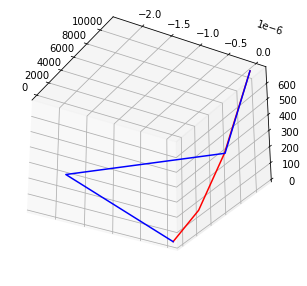

In [177]:
fig=plt.figure(figsize=(13,5))
ax = fig.gca(projection='3d')

X0=fin[0][[i for i in range(0,node_N)]]
Y0=fin[0][[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0][[i for i in range(4*node_N,5*node_N)]]
X=fin[-1][[i for i in range(0,node_N)]]
Y=fin[-1][[i for i in range(2*node_N,3*node_N)]]
Z=fin[-1][[i for i in range(4*node_N,5*node_N)]]
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
ax.view_init(-30,-30)
# ax.view_init(0,-90)
# ax.set_xlim([0, 5])
# ax.set_ylim([0, 5])
plt.show()

In [178]:
X,Y,Z

(array([    0.        ,  3684.24243474,  7368.45650464, 11052.68484446]),
 array([ 0.00000000e+00, -2.31833102e-06,  9.53576675e-09,  0.00000000e+00]),
 array([-6.80895844e-06,  7.70683442e+01,  3.08407642e+02,  6.94421895e+02]))

In [179]:
X0,Y0,Z0

(array([    0.        ,  3684.22828149,  7368.45656297, 11052.68484446]),
 array([0., 0., 0., 0.]),
 array([  0.        ,  77.06804645, 308.4070593 , 694.42189511]))

In [180]:
# E = 210e9

In [181]:
# E*Ar

In [182]:
# 1e10

In [183]:
# import torch

In [184]:
# A = torch.randn(20,3,3)
# B = torch.randn(20,3)
# X = torch.linalg.lstsq(A, B).solution # A is broadcasted to shape (2, 3, 3)


In [185]:
# X

In [186]:
# type(A)

In [187]:
# X.shape

In [188]:
plot3D(fin, numDataPoints, FPS, filename, 3)

TypeError: list indices must be integers or slices, not tuple